## Plot data

### HectorGravelPrime

Observation dimension is 49 \
Action dimension is 6 (centroidal linear acceleration, angular acceleration)

In [1]:
import os
import pickle
import glob

# from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
# %matplotlib widget

import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
# import torch

# Update Matplotlib's rcParams for paper-quality figures
mpl.rcParams.update({
    'font.family': 'serif',          # Use serif fonts (e.g., Times New Roman)
    'font.size': 9,                 # Base font size
    'axes.labelsize': 10,           # Font size for axis labels
    'axes.titlesize': 10,           # Font size for titles
    'xtick.labelsize': 8,           # Font size for x-axis tick labels
    'ytick.labelsize': 8,           # Font size for y-axis tick labels
    'legend.fontsize': 8,           # Font size for legend text
    'text.usetex': False,           # Use TeX for rendering text (set True for high-quality LaTeX output)
    'figure.dpi': 300,              # Higher resolution for publication
    'savefig.dpi': 300,             # Ensure saved figures have high resolution/home/jkamohara3/hector/IsaacLab/scripts/biped/plot
    'figure.figsize': (3.5, 2.5),   # Set figure size to match journal column width
    'axes.linewidth': 0.8,          # Thinner axis lines for a clean look
    'legend.frameon': False,         # Remove the legend frame for a cleaner appearance
    'lines.linewidth': 1.0          # Thinner plot lines for a clean look
}) 

In [2]:
def quaternion_to_euler(quats):
    """
    Convert a batch of quaternions to Euler angles (roll, pitch, yaw) using only NumPy.
    
    Parameters:
        quats (numpy.ndarray): Shape (batch_size, 4), where each row is [x, y, z, w]
    
    Returns:
        numpy.ndarray: Shape (batch_size, 3), where each row is [roll, pitch, yaw] in radians
    """
    w = quats[:, 0]
    x = quats[:, 1]
    y = quats[:, 2]
    z = quats[:, 3]

    # Roll (x-axis rotation)
    sinr_cosp = 2 * (w * x + y * z)
    cosr_cosp = 1 - 2 * (x * x + y * y)
    roll = np.arctan2(sinr_cosp, cosr_cosp)

    # Pitch (y-axis rotation)
    sinp = 2 * (w * y - z * x)
    pitch = np.where(np.abs(sinp) >= 1, np.sign(sinp) * np.pi / 2, np.arcsin(sinp))  # Handle gimbal lock

    # Yaw (z-axis rotation)
    siny_cosp = 2 * (w * z + x * y)
    cosy_cosp = 1 - 2 * (y * y + z * z)
    yaw = np.arctan2(siny_cosp, cosy_cosp)
    
    # normalize to -pi to pi
    roll = np.arctan2(np.sin(roll), np.cos(roll))
    pitch = np.arctan2(np.sin(pitch), np.cos(pitch))
    yaw = np.arctan2(np.sin(yaw), np.cos(yaw))

    return np.stack([roll, pitch, yaw], axis=1)  # Shape (batch_size, 3)

In [3]:
# data folder
# data_root = "../logs/Hector-Hierarchical-Prime-Full3-Rigid/2025-04-09_18-28-24/logs/mpc"
# data_root = "/home/jkamohara3/hector/isaac4.5/IsaacLab4.5/logs/rl_games/ppo_rl_games_stepping_stone_mlp/2025-04-17_18-23-54/logs/rl"
# data_root = "/home/jkamohara3/hector/isaac4.5/IsaacLab4.5/logs/rl_games/ppo_rl_games_stepping_stone_mlp/2025-04-18_02-06-50/logs/rl"
data_root = "/home/jkamohara3/hector/isaac4.5/IsaacLab4.5/logs/rl_games/manager_ppo_rl_games_stepping_stone_mlp/2025-04-26_02-35-21/logs/rl"

In [4]:
state_dir = os.path.join(data_root, "state")
obs_dir = os.path.join(data_root, "obs")
action_dir = os.path.join(data_root, "raw_action")
episode_length_dir = os.path.join(data_root, "episode")

# collect all the data
state_files = glob.glob(os.path.join(state_dir, "*.pkl"))
obs_files = glob.glob(os.path.join(obs_dir, "*.pkl"))
action_files = glob.glob(os.path.join(action_dir, "*.pkl"))
episode_files = glob.glob(os.path.join(episode_length_dir, "*.pkl"))


# sort the files
state_files.sort()
obs_files.sort()
action_files.sort()
episode_files.sort()

# load the data
for i in range(len(state_files)):
    state_file = state_files[i]
    obs_file = obs_files[i]
    action_file = action_files[i]
    episode_file = episode_files[i]

    with open(state_file, "rb") as f:
        state = pickle.load(f)
    with open(obs_file, "rb") as f:
        obs = pickle.load(f)
    with open(action_file, "rb") as f:
        action = pickle.load(f)
    with open(episode_file, "rb") as f:
        episode_length_data = pickle.load(f)

state_data = np.array(state)
obs_data = np.array(obs)
action_data = np.array(action)
mpc_action_data = obs_data[:, :, :, 50:56]
episode_length_data = np.array(episode_length_data)

episode_length = state_data.shape[0]
batch_size = state_data.shape[1]
time_step = state_data.shape[2]

state_data = state_data.reshape(episode_length*batch_size, time_step, -1)

# time step
num_history = 1
height_w, height_h = 11, 11
height_scan_num = height_w * height_h
obs_data = obs_data.reshape(episode_length*batch_size, time_step, -1)
height_data = obs_data[:, :, -height_scan_num:]
obs_data = obs_data[:, :, :-height_scan_num].reshape(episode_length*batch_size, time_step, num_history, -1)[:, :, -1, :]
action_data = action_data.reshape(episode_length*batch_size, time_step, -1)
mpc_action_data = mpc_action_data.reshape(episode_length*batch_size, time_step, -1)
episode_length_data = episode_length_data.reshape(-1)


num_envs = obs_data.shape[0]
print("==== baseline mpc ====")
print("number of envs: ", obs_data.shape[0])
print("state dimension: ", state_data.shape)
print("observersation dimension: ", obs_data.shape)
print("action dimension: ", action_data.shape)

==== baseline mpc ====
number of envs:  1
state dimension:  (1, 2000, 33)
observersation dimension:  (1, 2000, 64)
action dimension:  (1, 2000, 3)


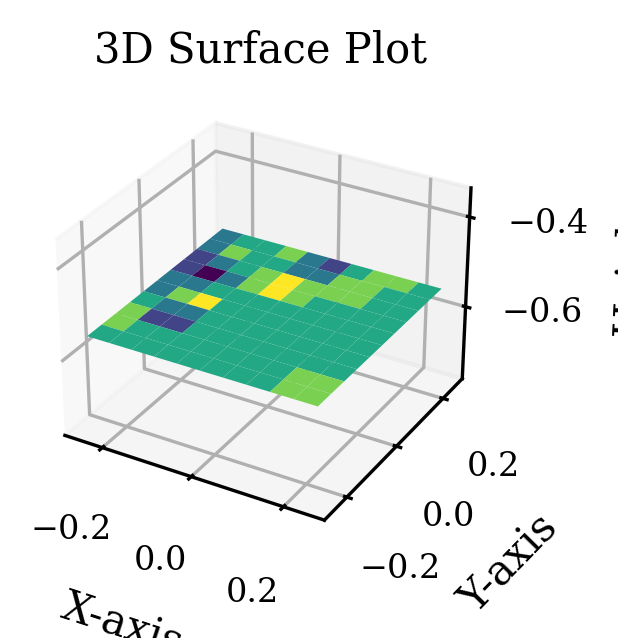

In [5]:
height = height_data[0][5].reshape(height_h, height_w)
# 3D plot
fig = plt.figure(figsize=(5, 2))
ax = fig.add_subplot(111, projection='3d')
x = np.linspace(-0.25, 0.25, height_w)
y = np.linspace(-0.25, 0.25, height_h)
X, Y = np.meshgrid(x, y)

ax.plot_surface(X, Y, height, cmap='viridis', edgecolor='none')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Height')
ax.set_title('3D Surface Plot')

# plt.tight_layout()
plt.axis('equal')  # Comment out for 3D
plt.show()

In [67]:
dt_policy = 0.01

# observation indices
height_indies = 0
orientation_indies = slice(1, 5)
linear_velocity_indies = slice(5, 7)
angular_velocity_indies = 10
desired_linear_velocity_indies = slice(11, 13)
desired_angular_velocity_indies = 13
joint_pos_indies = slice(14, 24)
joint_vel_indies = slice(24, 34)
jont_effort_indices = slice(34, 44)
mpc_action_indices = slice(44, 50)
gait_contact_indices = slice(50, 52)
swing_phase_indices = slice(52, 54)
raibert_fps_indices = slice(54, 58)
augmented_fps_indices = slice(58, 62)
previous_action_indices = slice(62, 82)

velocity_x = obs_data[:, :, linear_velocity_indies][:, :, 0]
desired_velocity_x = obs_data[:, :, desired_linear_velocity_indies][:, :, 0]
ang_velocity = obs_data[:, :, angular_velocity_indies]
desired_ang_velocity = obs_data[:, :, desired_angular_velocity_indies]

joint_pos = obs_data[:, :, joint_pos_indies]
joint_vel = obs_data[:, :, joint_vel_indies]
joint_effort = obs_data[:, :, jont_effort_indices]
mpc_action = obs_data[:, :, mpc_action_indices]
gait_contact = obs_data[:, :, gait_contact_indices]
swing_phase = obs_data[:, :, swing_phase_indices]
raibert_fps = obs_data[:, :, raibert_fps_indices]
augmented_fps = obs_data[:, :, augmented_fps_indices]

# state indices
state_position_indices = slice(0, 3)
state_quat_indices = slice(3, 7)
velocity_indices = slice(7, 10)
ang_velocity_indices = slice(10, 13)

position = state_data[:, :, state_position_indices]
quat = state_data[:, :, state_quat_indices]
euler = (180/np.pi) * quaternion_to_euler(quat.reshape(-1, 4)).reshape(num_envs, -1, 3)
velocity = state_data[:, :, velocity_indices]
ang_velocity = state_data[:, :, ang_velocity_indices]

position_des = np.zeros_like(state_data[:, :, state_position_indices])
orientation_des = np.zeros_like(state_data[:, :, state_position_indices])

orientation_des[:, :, 2] = np.cumsum(desired_ang_velocity*dt_policy, axis=1)
orientation_des[:, :, 2] = np.arctan2(np.sin(orientation_des[:, :, 2]), np.cos(orientation_des[:, :, 2]))

position_des[:, :, 0] = np.cumsum(desired_velocity_x*np.cos(orientation_des[:, :, 2])*dt_policy, axis=1)
position_des[:, :, 1] = np.cumsum(desired_velocity_x*np.sin(orientation_des[:, :, 2])*dt_policy, axis=1)
position_des[:, :, 2] = 0.55 * np.ones_like(position_des[:, :, 2])

# change to deg
orientation_des = (180/np.pi) * orientation_des

## Observation check

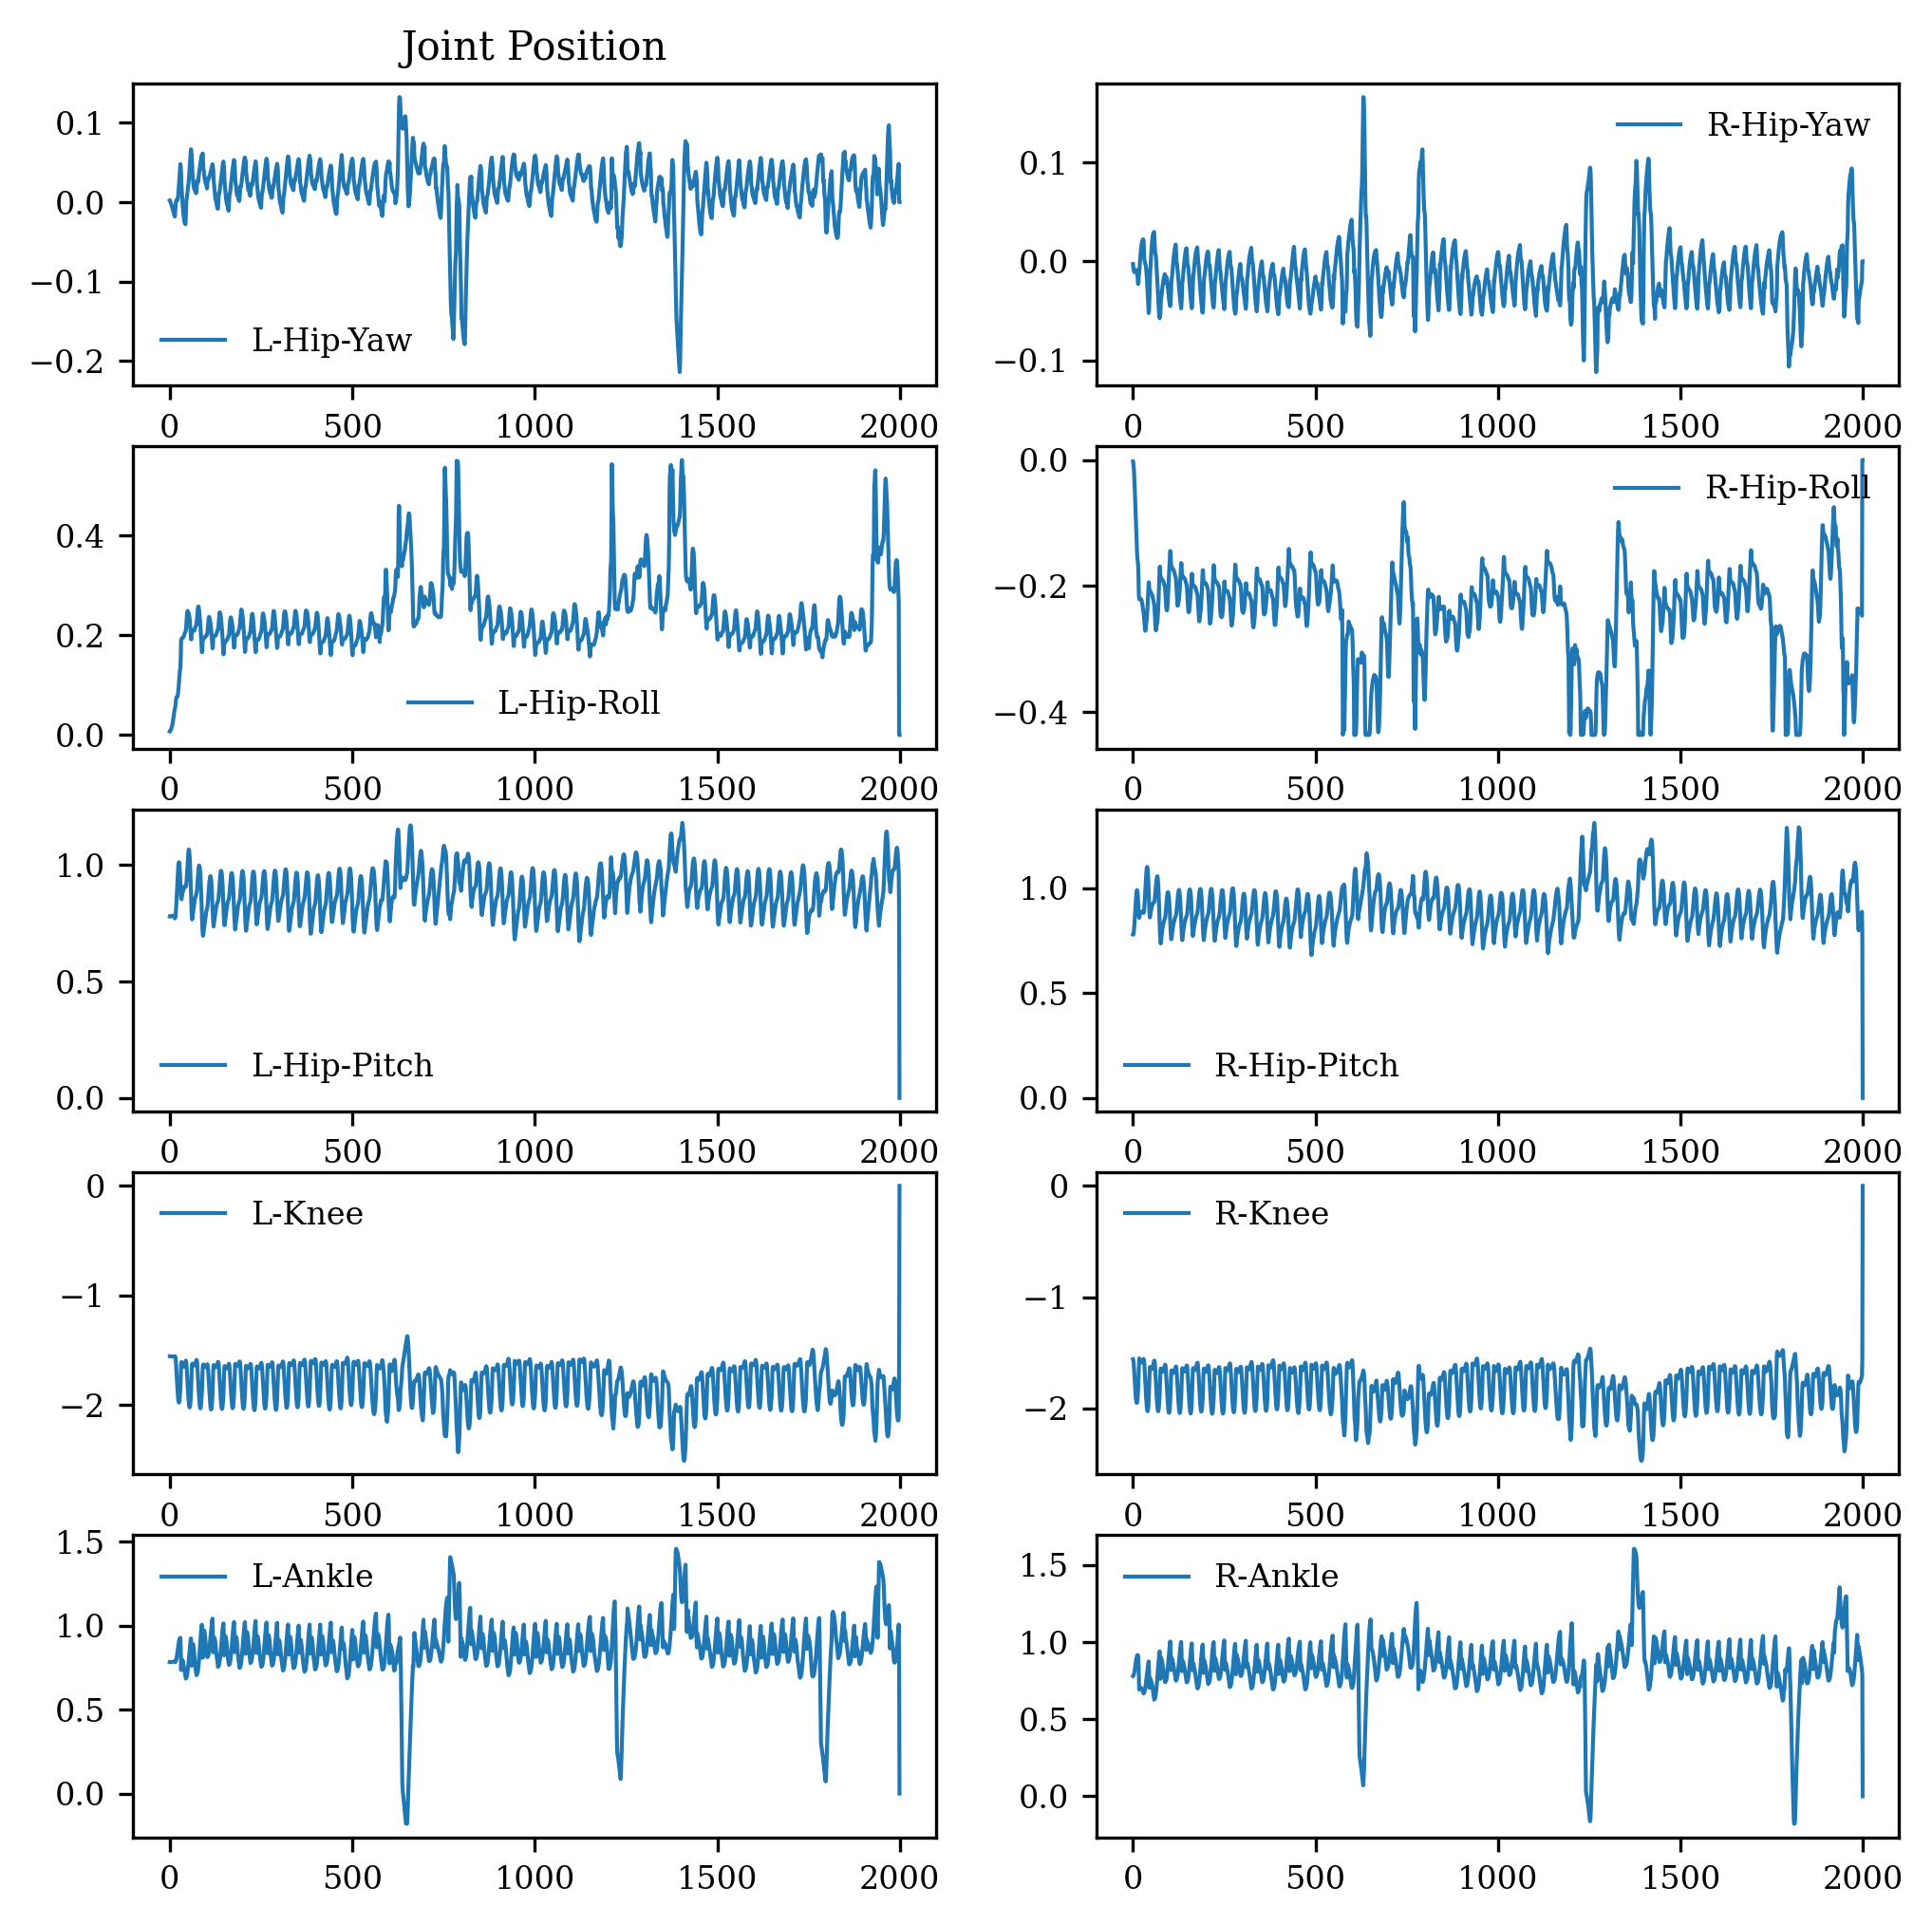

In [19]:
plt.figure(figsize=(8, 8))

plt.subplot(5, 2, 1)
plt.plot(joint_pos[0, :, 0], label="L-Hip-Yaw")
plt.title("Joint Position")
plt.legend()

plt.subplot(5, 2, 2)
plt.plot(joint_pos[0, :, 5], label="R-Hip-Yaw")
plt.legend()

plt.subplot(5, 2, 3)
plt.plot(joint_pos[0, :, 1], label="L-Hip-Roll")
plt.legend()

plt.subplot(5, 2, 4)
plt.plot(joint_pos[0, :, 6], label="R-Hip-Roll")
plt.legend()

plt.subplot(5, 2, 5)
plt.plot(joint_pos[0, :, 2], label="L-Hip-Pitch")
plt.legend()

plt.subplot(5, 2, 6)
plt.plot(joint_pos[0, :, 7], label="R-Hip-Pitch")
plt.legend()

plt.subplot(5, 2, 7)
plt.plot(joint_pos[0, :, 3], label="L-Knee")
plt.legend()

plt.subplot(5, 2, 8)
plt.plot(joint_pos[0, :, 8], label="R-Knee")
plt.legend()

plt.subplot(5, 2, 9)
plt.plot(joint_pos[0, :, 4], label="L-Ankle")
plt.legend()

plt.subplot(5, 2, 10)
plt.plot(joint_pos[0, :, 9], label="R-Ankle")
plt.legend()

plt.show()

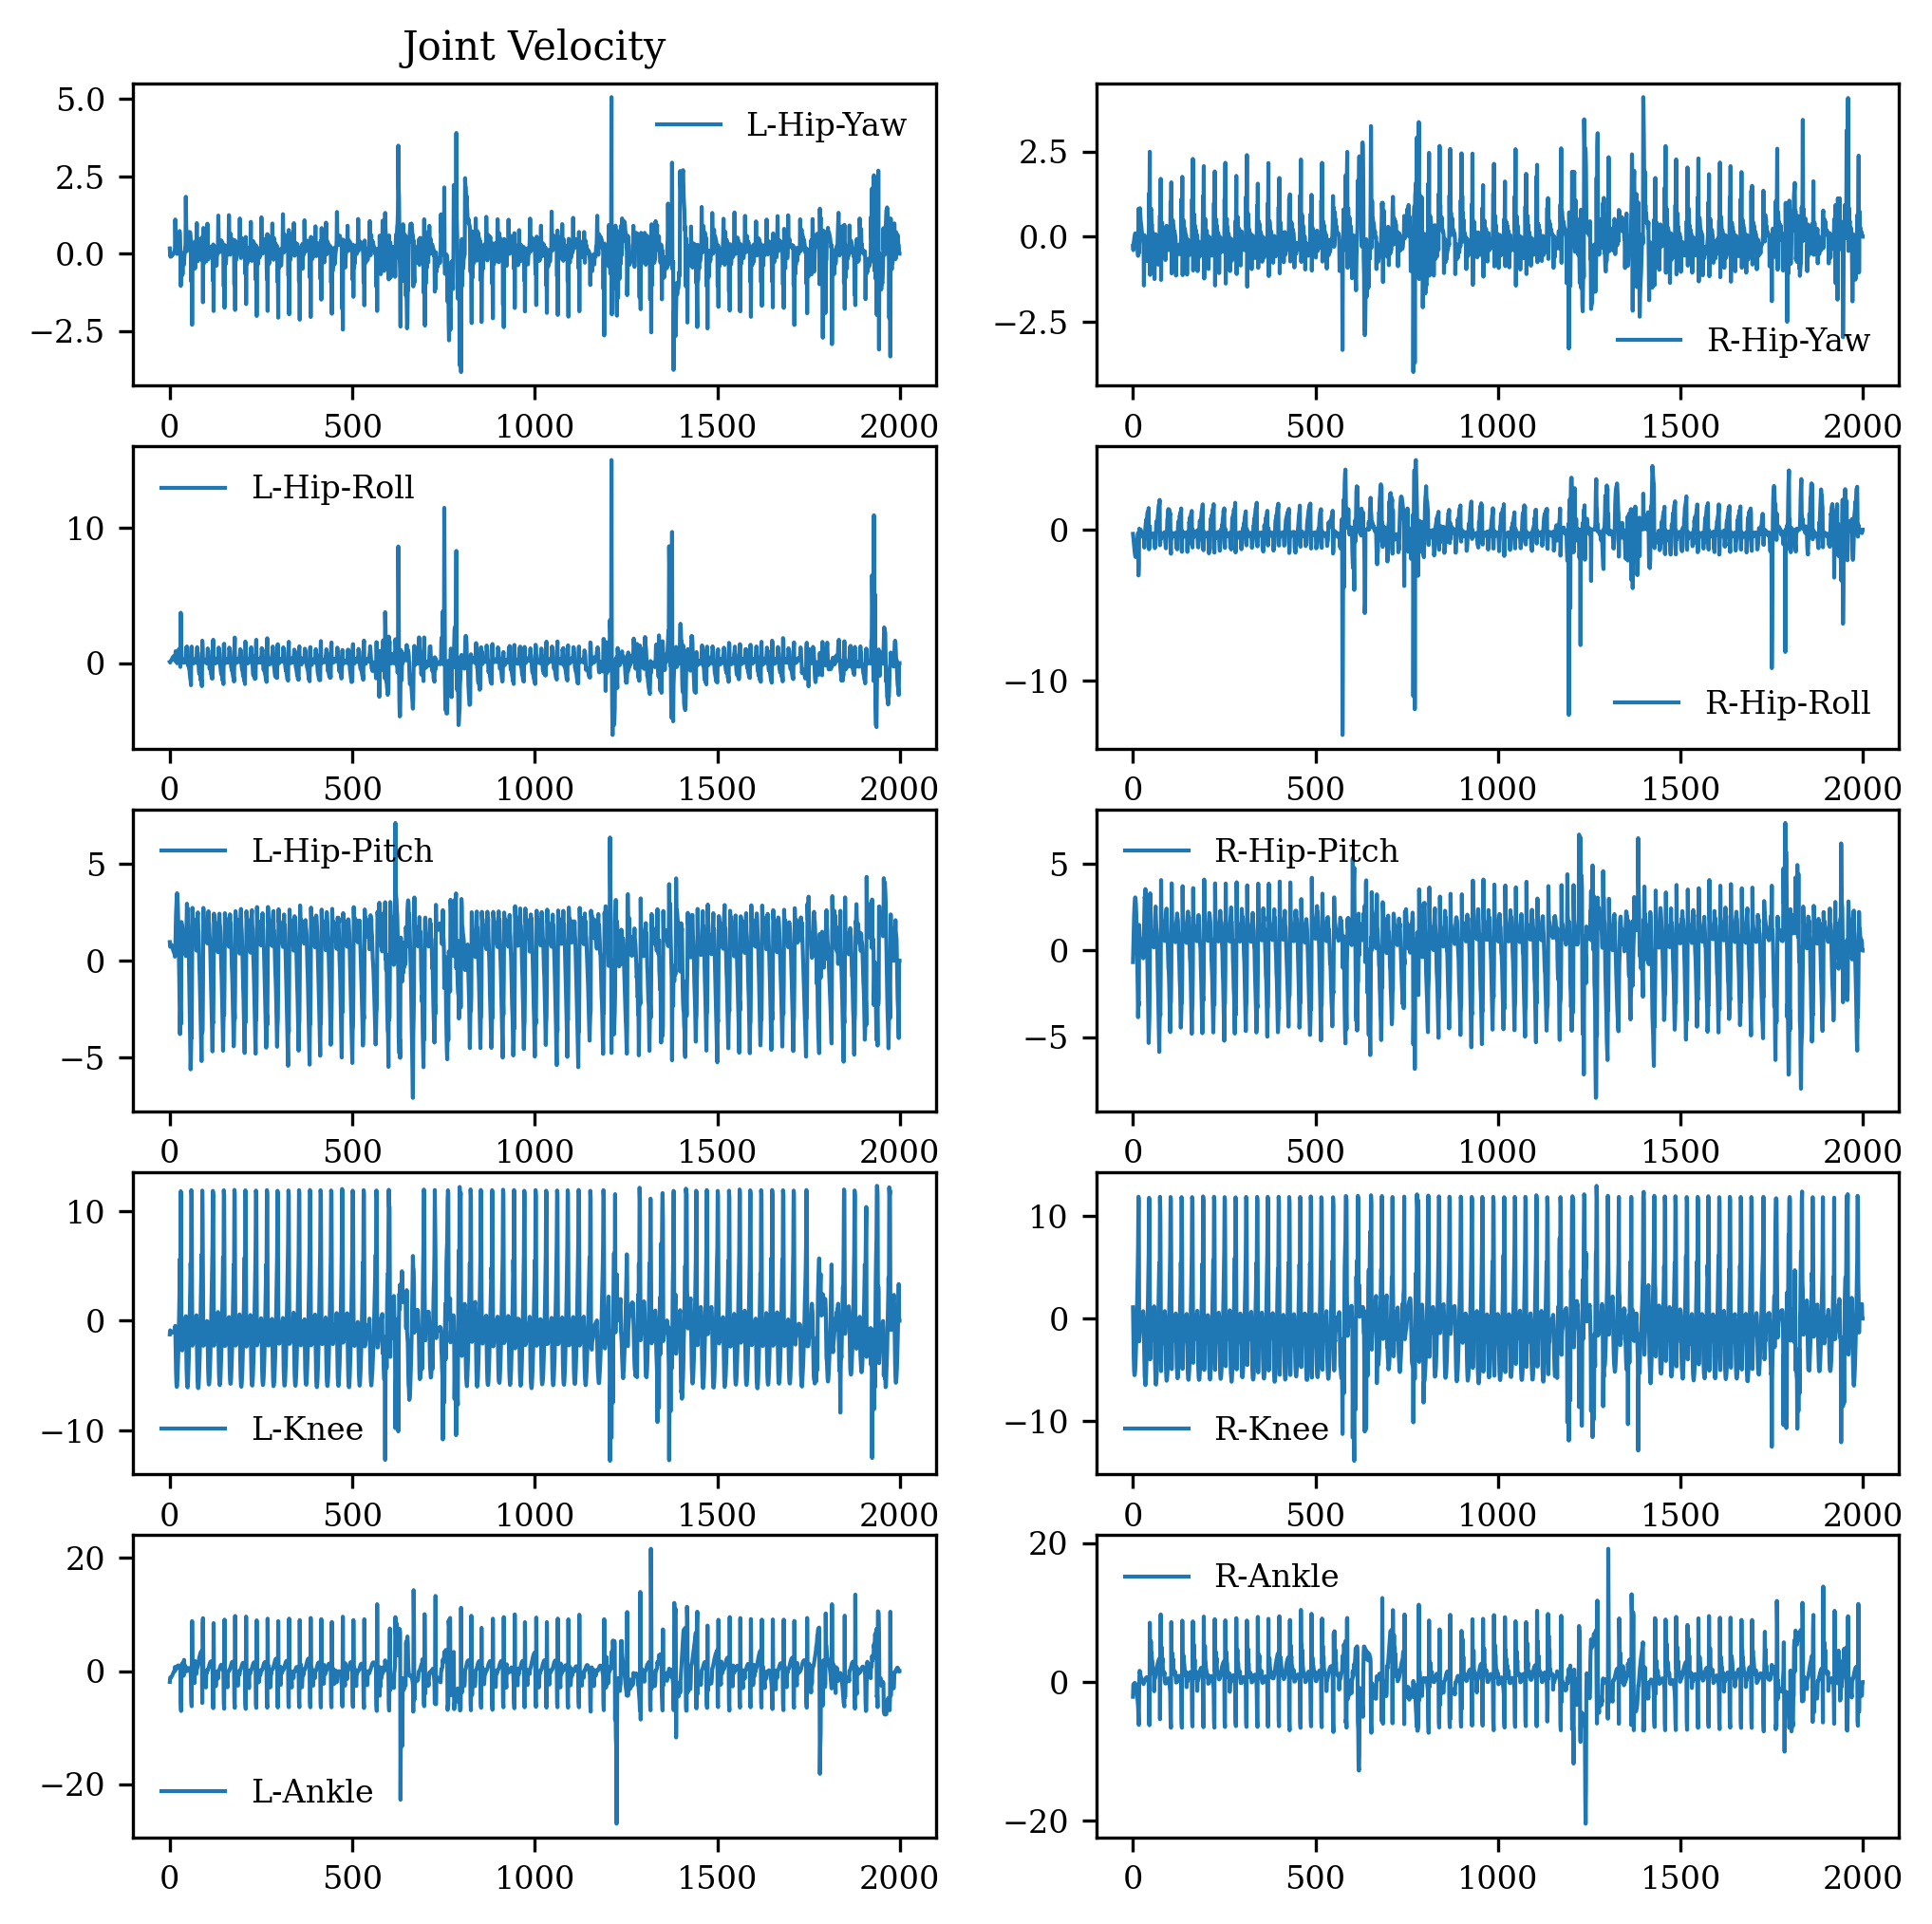

In [20]:
plt.figure(figsize=(8, 8))

plt.subplot(5, 2, 1)
plt.title("Joint Velocity")
plt.plot(joint_vel[0, :, 0], label="L-Hip-Yaw")
plt.legend()

plt.subplot(5, 2, 2)
plt.plot(joint_vel[0, :, 5], label="R-Hip-Yaw")
plt.legend()

plt.subplot(5, 2, 3)
plt.plot(joint_vel[0, :, 1], label="L-Hip-Roll")
plt.legend()

plt.subplot(5, 2, 4)
plt.plot(joint_vel[0, :, 6], label="R-Hip-Roll")
plt.legend()

plt.subplot(5, 2, 5)
plt.plot(joint_vel[0, :, 2], label="L-Hip-Pitch")
plt.legend()

plt.subplot(5, 2, 6)
plt.plot(joint_vel[0, :, 7], label="R-Hip-Pitch")
plt.legend()

plt.subplot(5, 2, 7)
plt.plot(joint_vel[0, :, 3], label="L-Knee")
plt.legend()

plt.subplot(5, 2, 8)
plt.plot(joint_vel[0, :, 8], label="R-Knee")
plt.legend()

plt.subplot(5, 2, 9)
plt.plot(joint_vel[0, :, 4], label="L-Ankle")
plt.legend()

plt.subplot(5, 2, 10)
plt.plot(joint_vel[0, :, 9], label="R-Ankle")
plt.legend()

plt.show()

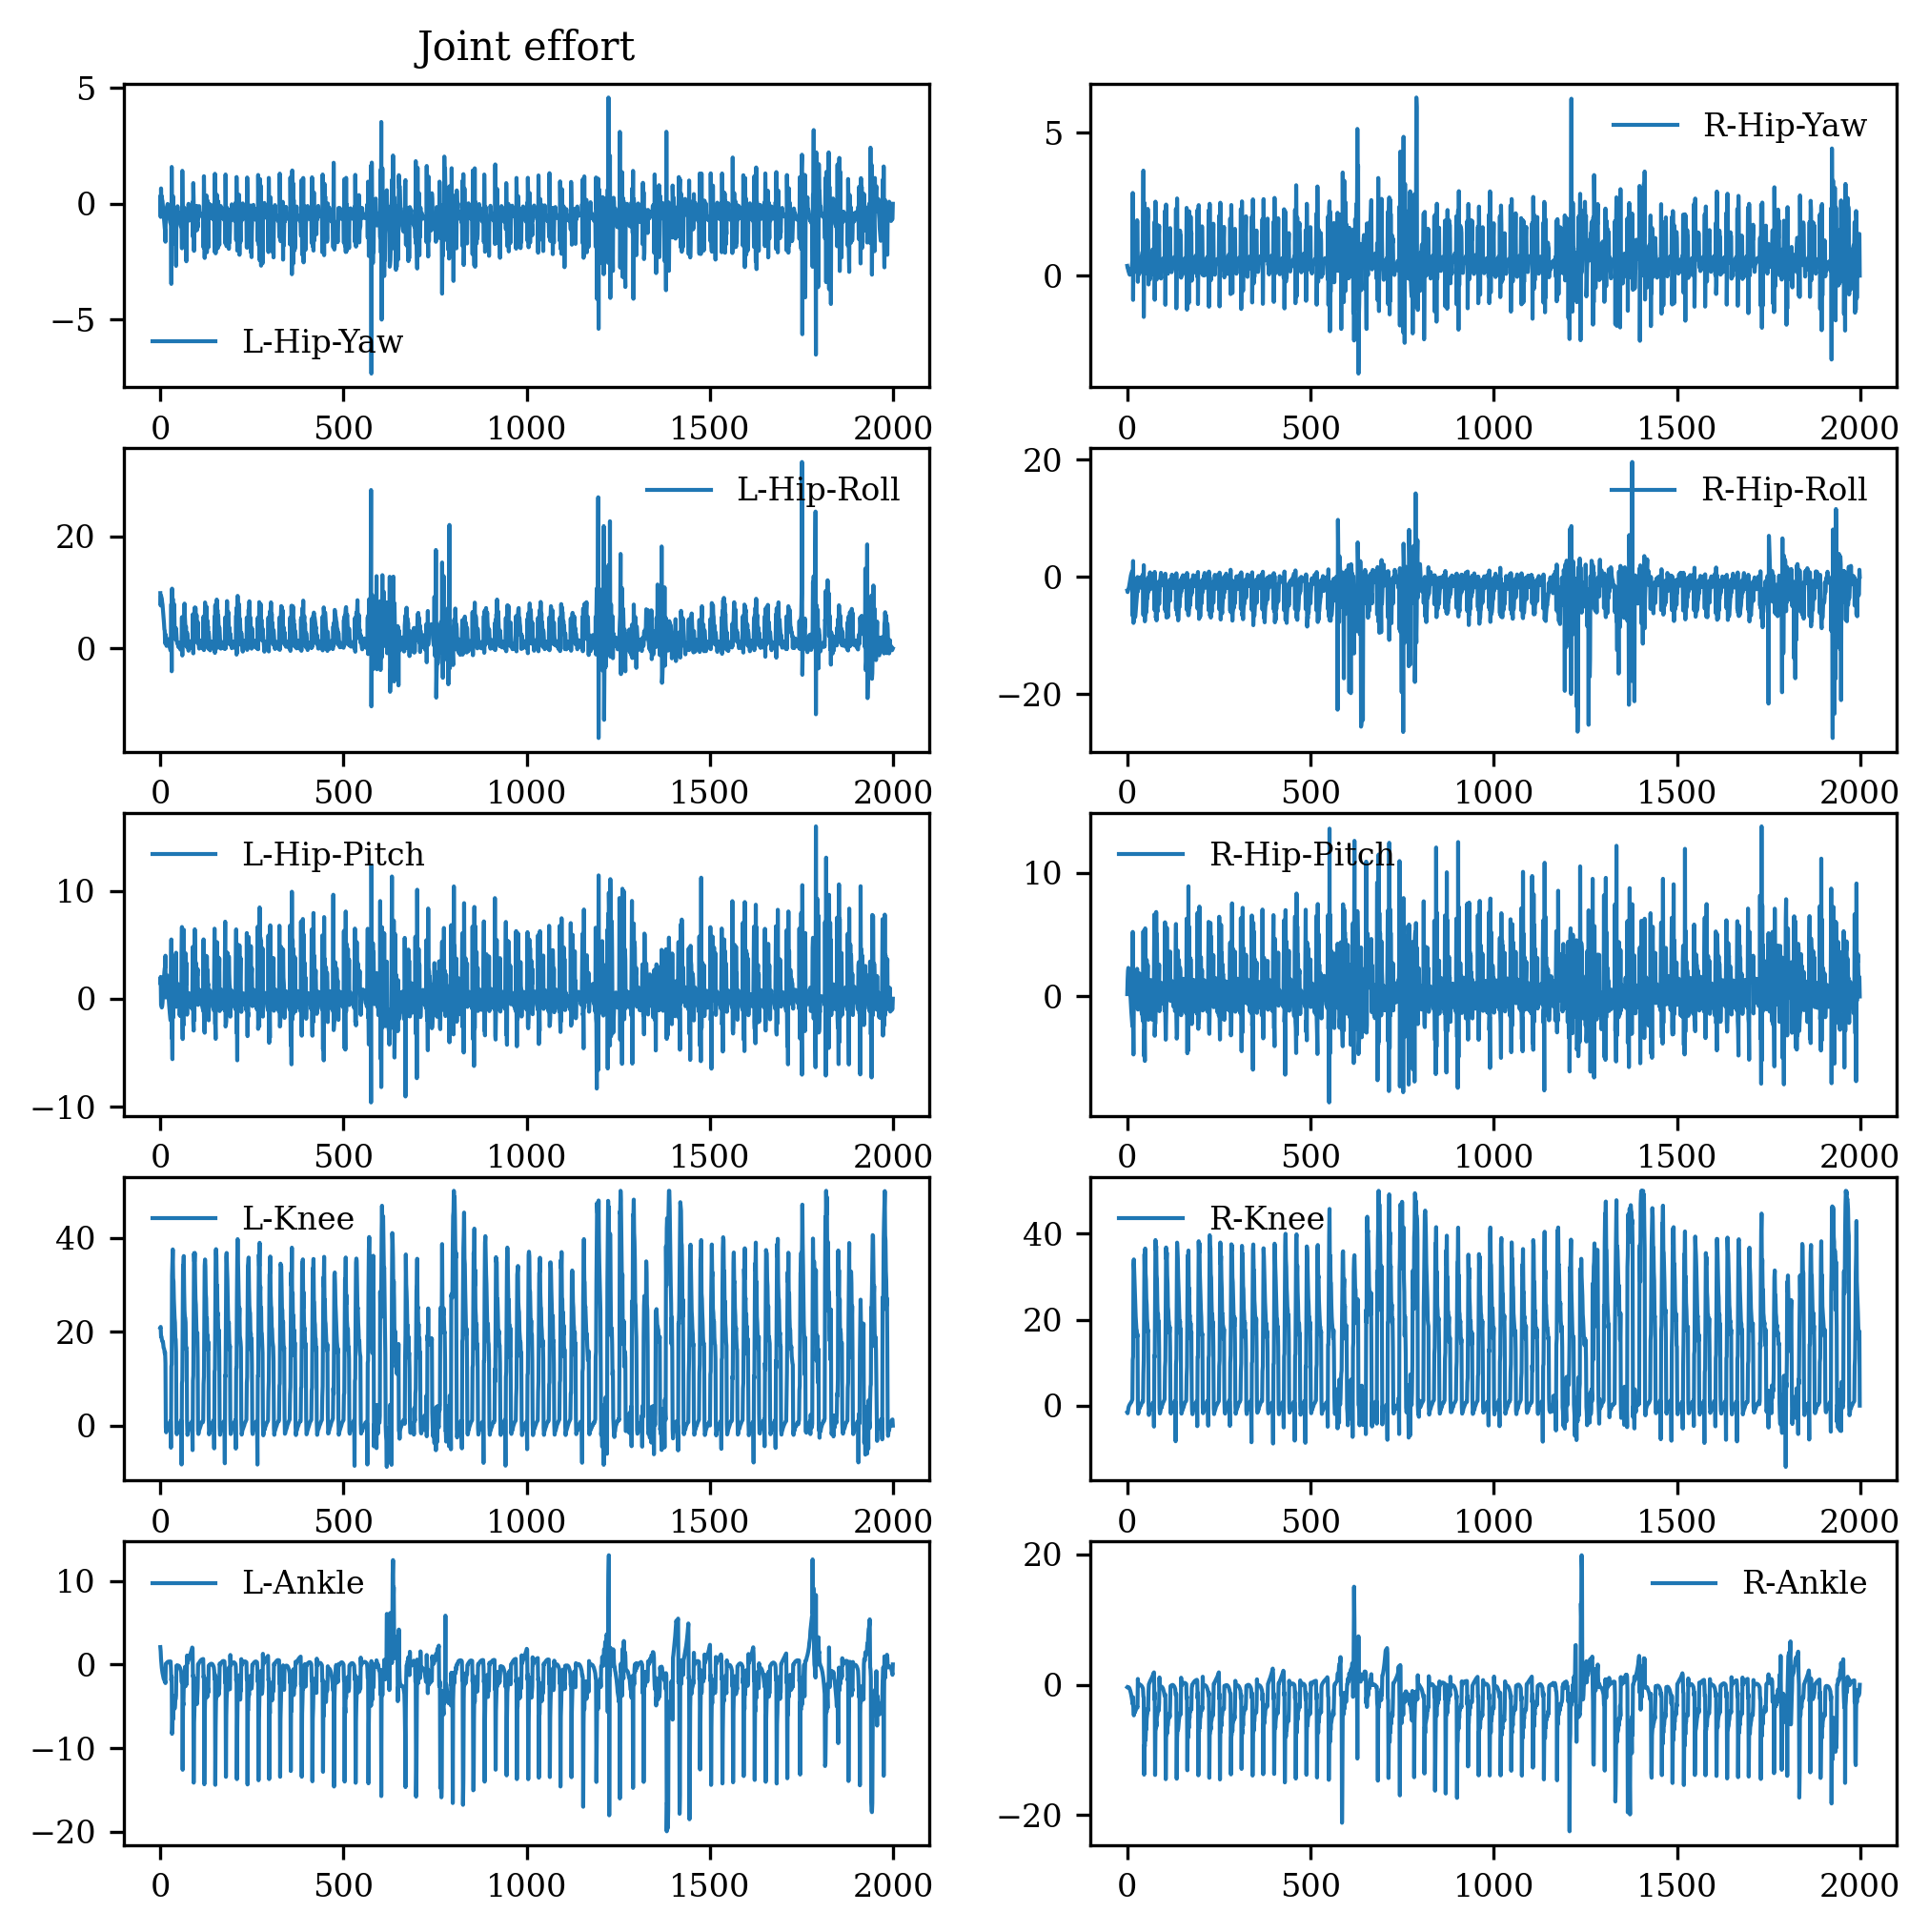

In [21]:
plt.figure(figsize=(8, 8))

plt.subplot(5, 2, 1)
plt.title("Joint effort")
plt.plot(joint_effort[0, :, 0], label="L-Hip-Yaw")
plt.legend()

plt.subplot(5, 2, 2)
plt.plot(joint_effort[0, :, 5], label="R-Hip-Yaw")
plt.legend()

plt.subplot(5, 2, 3)
plt.plot(joint_effort[0, :, 1], label="L-Hip-Roll")
plt.legend()

plt.subplot(5, 2, 4)
plt.plot(joint_effort[0, :, 6], label="R-Hip-Roll")
plt.legend()

plt.subplot(5, 2, 5)
plt.plot(joint_effort[0, :, 2], label="L-Hip-Pitch")
plt.legend()

plt.subplot(5, 2, 6)
plt.plot(joint_effort[0, :, 7], label="R-Hip-Pitch")
plt.legend()

plt.subplot(5, 2, 7)
plt.plot(joint_effort[0, :, 3], label="L-Knee")
plt.legend()

plt.subplot(5, 2, 8)
plt.plot(joint_effort[0, :, 8], label="R-Knee")
plt.legend()

plt.subplot(5, 2, 9)
plt.plot(joint_effort[0, :, 4], label="L-Ankle")
plt.legend()

plt.subplot(5, 2, 10)
plt.plot(joint_effort[0, :, 9], label="R-Ankle")
plt.legend()

plt.show()

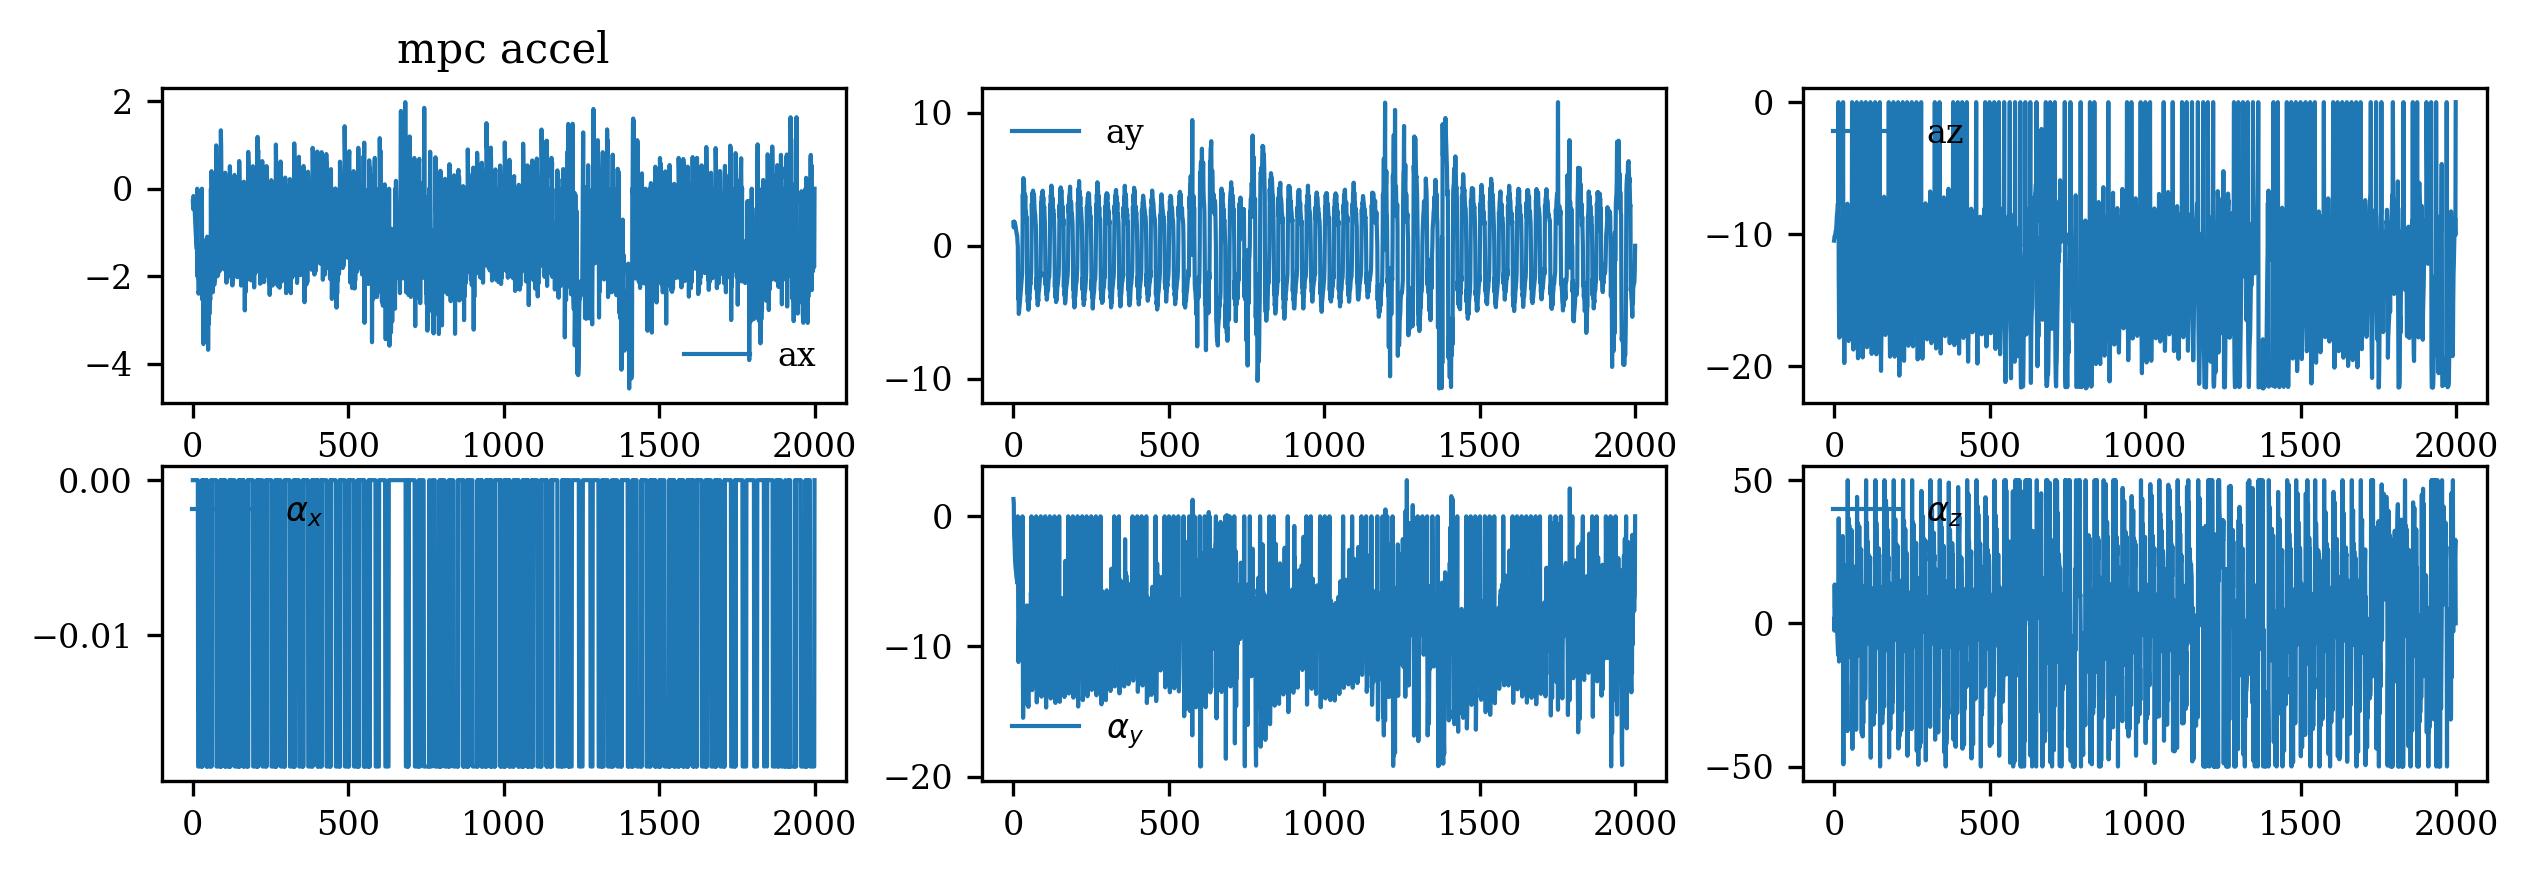

In [22]:
plt.figure(figsize=(10, 3))

plt.subplot(2, 3, 1)
plt.title("mpc accel")
plt.plot(mpc_action[0, :, 0], label="ax")
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(mpc_action[0, :, 1], label="ay")
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(mpc_action[0, :, 2], label="az")
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(mpc_action[0, :, 3], label=r"$\alpha_x$")
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(mpc_action[0, :, 4], label=r"$\alpha_y$")
plt.legend()

plt.subplot(2, 3, 6)
plt.plot(mpc_action[0, :, 5], label=r"$\alpha_z$")
plt.legend()

plt.show()

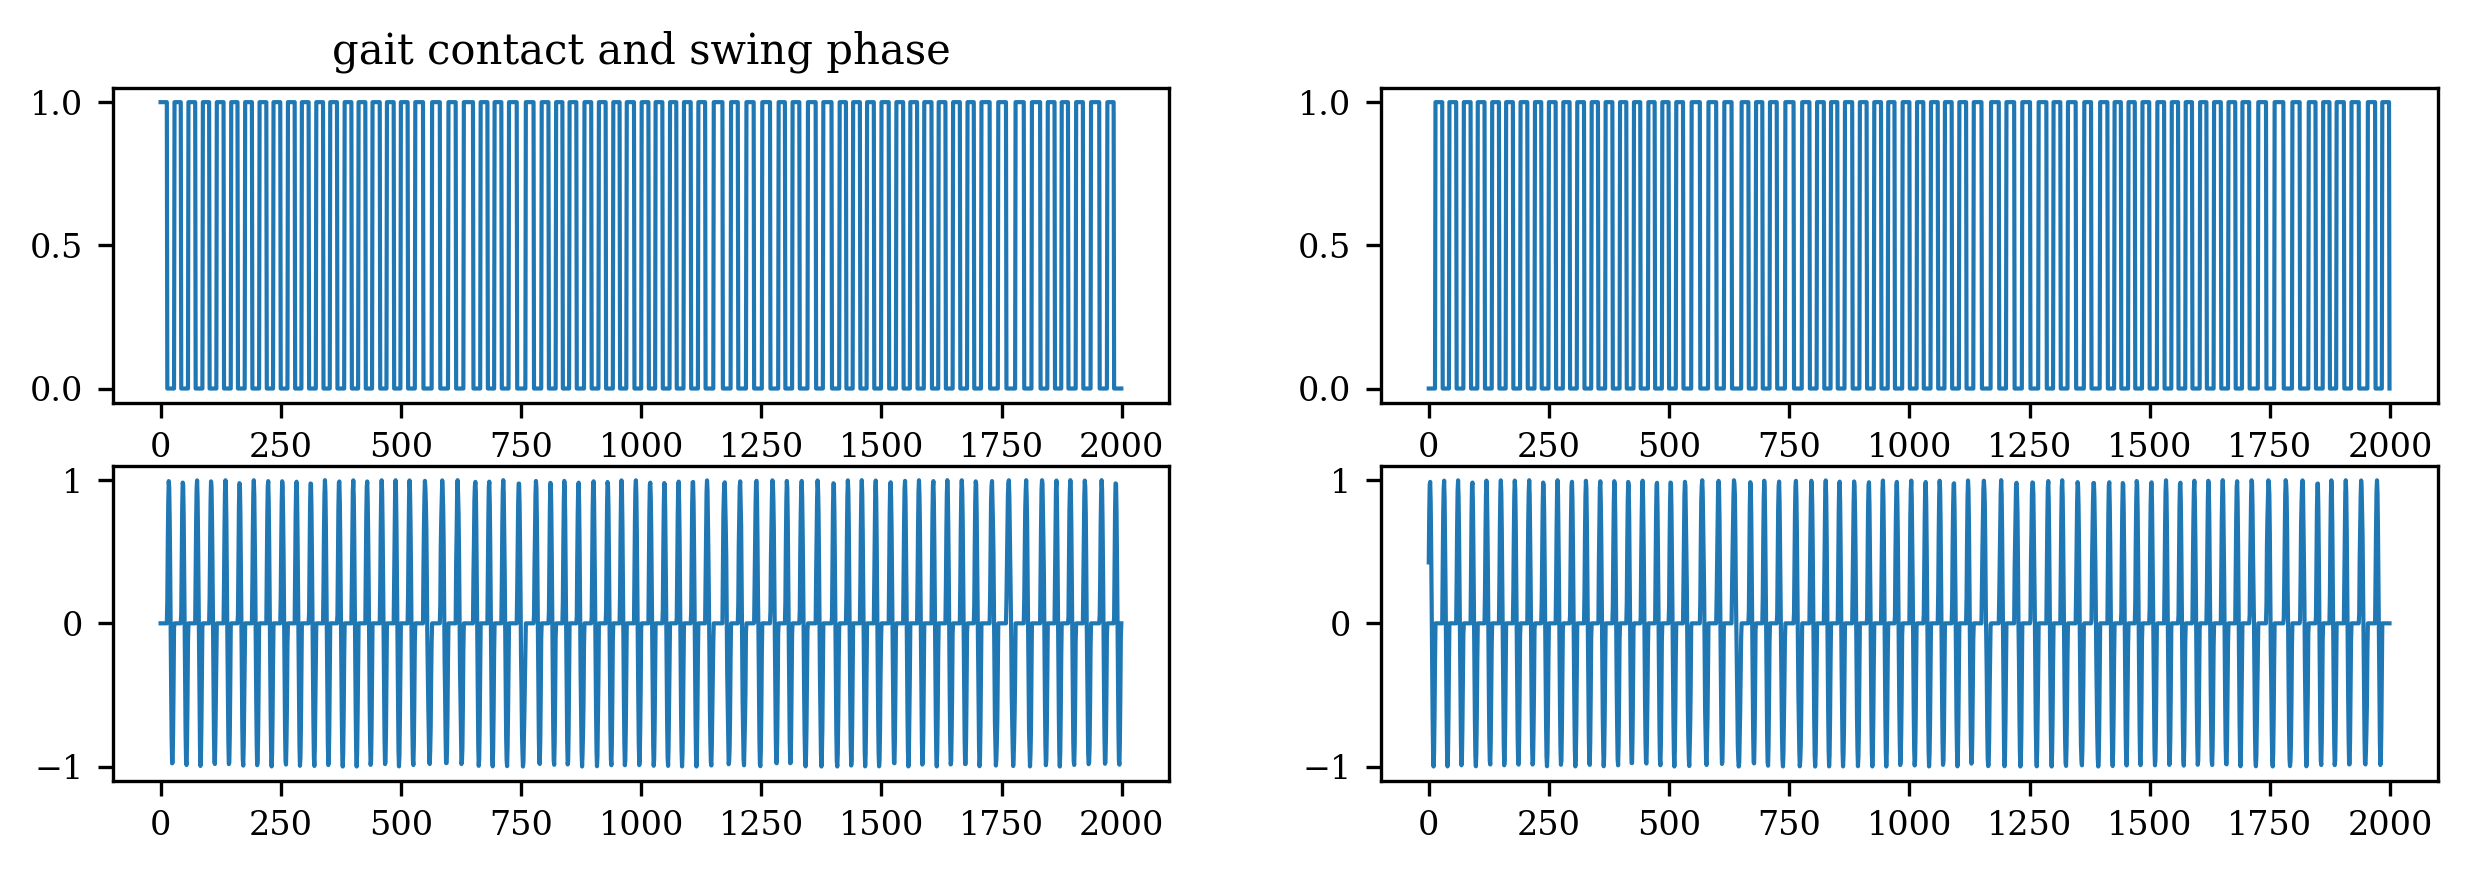

In [23]:
gait_contact.shape

plt.figure(figsize=(10, 3))

plt.subplot(2, 2, 1)
plt.title("gait contact and swing phase")
plt.plot(gait_contact[0, :, 0], label="L")

plt.subplot(2, 2, 2)
plt.plot(gait_contact[0, :, 1], label="R")

plt.subplot(2, 2, 3)
# plt.plot(swing_phase[0, :, 0], label="L")
plt.plot(np.sin(2*np.pi*swing_phase[0, :, 0]), label="L")

plt.subplot(2, 2, 4)
# plt.plot(swing_phase[0, :, 1], label="R")
plt.plot(np.sin(2*np.pi*swing_phase[0, :, 1]), label="R")

plt.show()

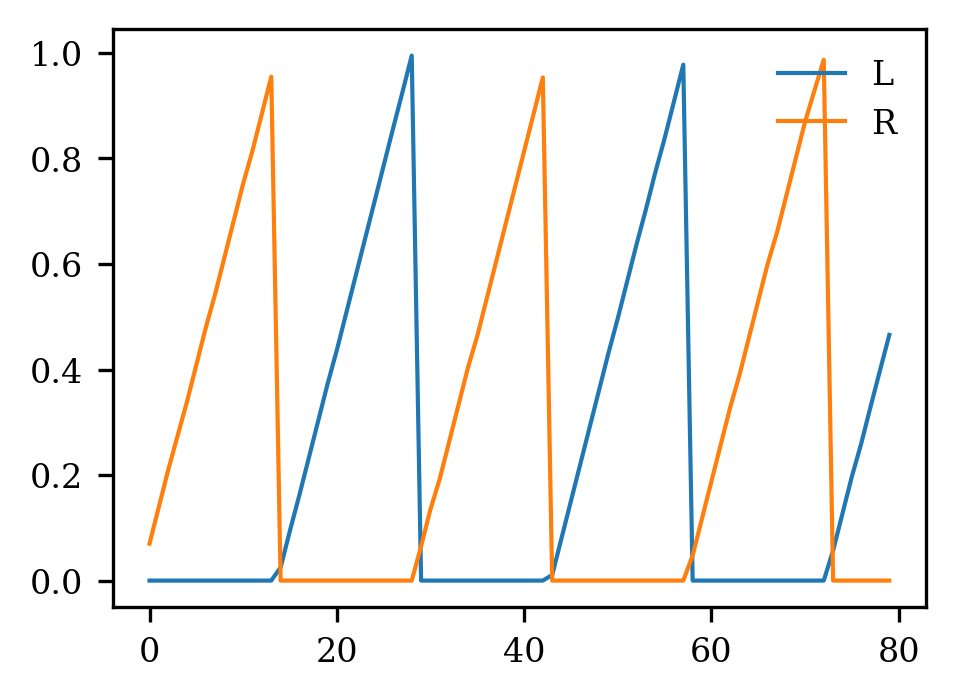

In [24]:
# plt.plot(np.sin(2*np.pi*swing_phase[0, :100, 1]), label="R")
plt.plot(swing_phase[0, :80, 0], label="L")
plt.plot(swing_phase[0, :80, 1], label="R")
plt.legend()
plt.show()

## Plot results

### Tracking error

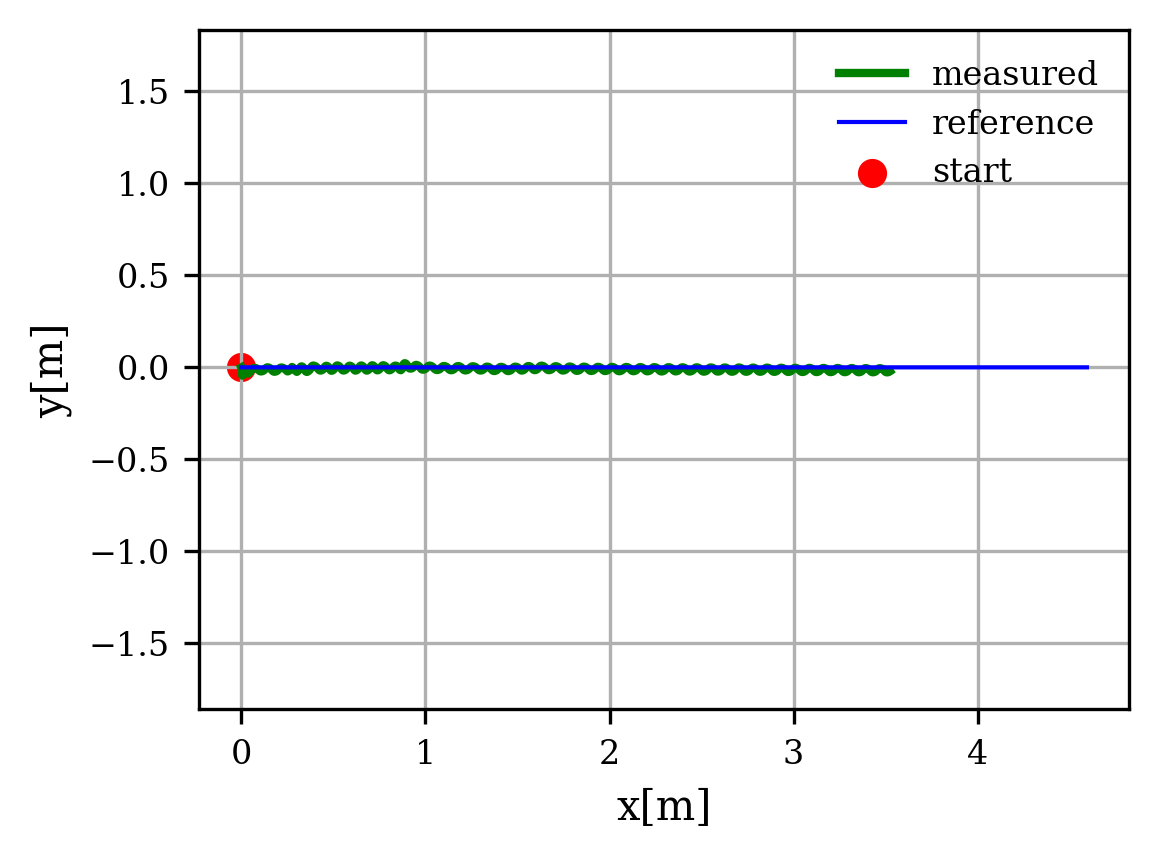

In [187]:
plt.figure(figsize=(4, 3))
num_sample = 1

for i in range(num_sample):
    t = (5 * 1/500) * np.arange(velocity_x[i].shape[0])
    pos = position[i]
    pos_des = position_des[i]
    
    pos_x = pos[:-1, 0]
    pos_y = pos[:-1, 1]
    pos_des_x = pos_des[:-1, 0]
    pos_des_y = pos_des[:-1, 1]
    
    plt.plot(pos_x, pos_y, label="measured", c="green", linewidth=2.0)
    plt.plot(pos_des_x, pos_des_y, label="reference", c="blue", linewidth=1.0)
    plt.scatter(pos_x[0], pos_y[0], c="red", label="start")
    plt.xlabel("x[m]")
    plt.ylabel("y[m]")
    plt.grid()
    plt.axis("equal")
    plt.legend(loc="best")

# plt.savefig("trajectory_inf.png")
# plt.savefig("trajectory_circle.png")
plt.show()

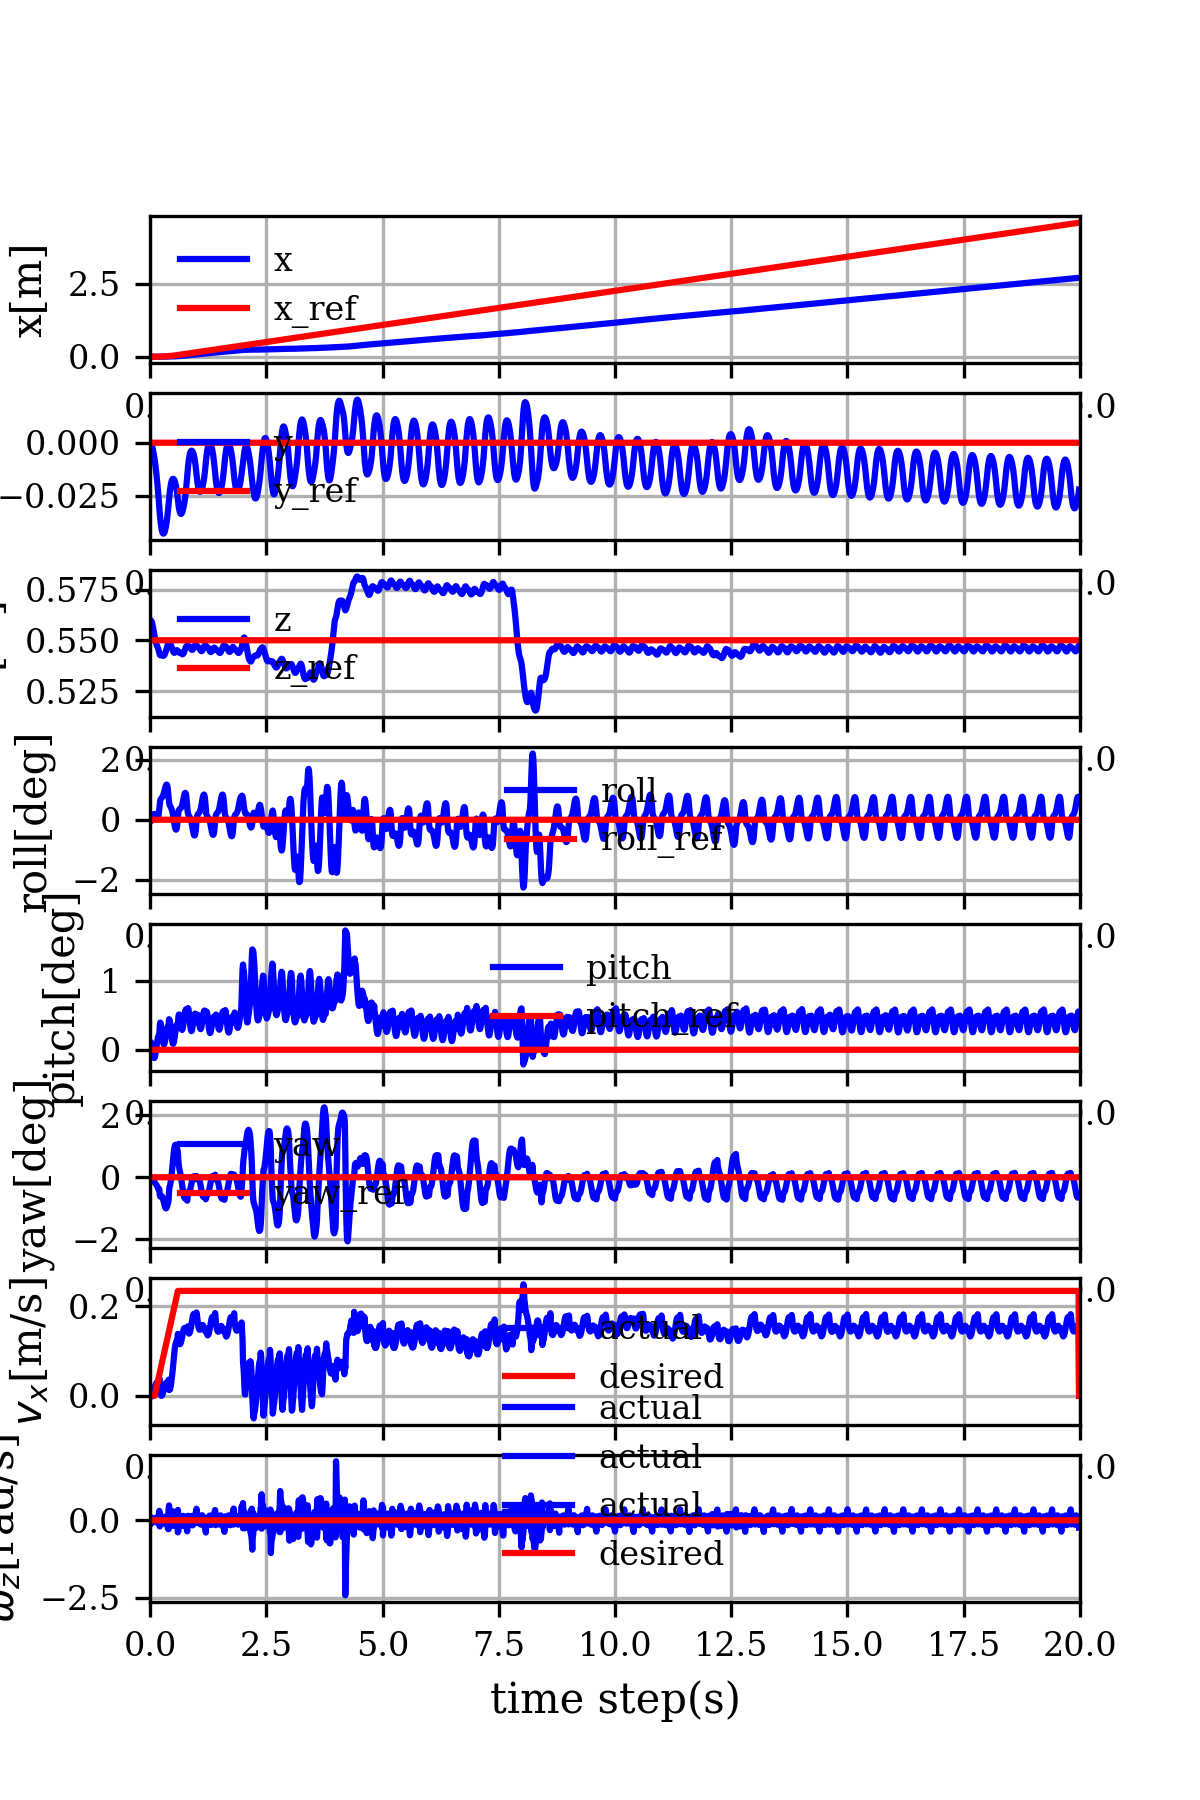

In [16]:
plt.figure(figsize=(4, 6))
num_sample = 1
# num_sample = len(velocity_x)

for i in range(num_sample):
    i = 0
    t = (5 * 1/500) * np.arange(velocity_x[i].shape[0])
    pos = position[i]
    orientation = euler[i]
    pos_x = pos[:, 0]
    pos_y = pos[:, 1]
    pos_z = pos[:, 2]
    roll = orientation[:, 0]
    pitch = orientation[:, 1]
    yaw = orientation[:, 2]
    
    plt.subplot(8, 1, 1)
    plt.plot(t[:-1], pos_x[:-1], label="x", color="b")
    plt.plot(t[:-1], position_des[i, :-1, 0], label="x_ref", color="r")
    plt.ylabel("x[m]")
    # plt.ylim(-1.0, 1.5)
    # plt.ylim(-0.5, 0.5)
    plt.xlim(0, np.max(t+0.01))
    plt.legend()
    plt.grid()
    
    plt.subplot(8, 1, 2)
    plt.plot(t[:-1], pos_y[:-1], label="y", color="b")
    plt.plot(t[:-1], position_des[i, :-1, 1], label="y_ref", color="r")
    plt.ylabel("y[m]")
    # plt.ylim(-0.5, 0.5)
    plt.xlim(0, np.max(t+0.01))
    plt.legend()
    plt.grid()
    
    plt.subplot(8, 1, 3)
    plt.plot(t[:-1], pos_z[:-1], label="z", color="b")
    plt.plot(t[:-1], position_des[i, :-1, 2], label="z_ref", color="r")
    plt.ylabel("z[m]")
    plt.xlim(0, np.max(t+0.01))
    plt.legend()
    plt.grid()
    
    plt.subplot(8, 1, 4)
    plt.plot(t[:-1], roll[:-1], label="roll", color="b")
    plt.plot(t[:-1], orientation_des[i, :-1, 0], label="roll_ref", color="r")
    plt.ylabel("roll[deg]")
    plt.xlim(0, np.max(t+0.01))
    plt.legend()
    plt.grid()
    
    plt.subplot(8, 1, 5)
    plt.plot(t[:-1], pitch[:-1], label="pitch", color="b")
    plt.plot(t[:-1], orientation_des[i, :-1, 1], label="pitch_ref", color="r")
    plt.ylabel("pitch[deg]")
    plt.xlim(0, np.max(t+0.01))
    plt.legend()
    plt.grid()
    
    plt.subplot(8, 1, 6)
    plt.plot(t[:-1], yaw[:-1], label="yaw", color="b")
    plt.plot(t[:-1], orientation_des[i, :-1, 2], label="yaw_ref", color="r")
    # plt.ylim(-180, 180)
    plt.ylabel("yaw[deg]")
    plt.xlim(0, np.max(t+0.01))
    plt.legend()
    plt.grid()
    
    plt.subplot(8, 1, 7)
    plt.plot(t[:-1], velocity_x[i, :-1], label="actual", color="b")
    plt.plot(t[:-1], desired_velocity_x[i,:-1], label="desired", color="r")
    plt.ylabel(r"$v_x$[m/s]")
    plt.xlim(0, np.max(t+0.01))
    plt.legend()
    plt.grid()
    
    plt.subplot(8, 1, 8)
    plt.plot(t[:-1], ang_velocity[i, :-1], label="actual", color="b")
    plt.plot(t[:-1], desired_ang_velocity[i,:-1], label="desired", color="r")
    plt.ylabel(r"$\omega_z$[rad/s]")
    plt.xlabel("time step(s)")
    plt.xlim(0, np.max(t+0.01))
    plt.legend()
    plt.grid()

# plt.savefig("trajectory_inf_full.png")
# plt.savefig("trajectory_circle_full.png")
# plt.savefig("chunk_data/trajectory_single_point.jpg")
# plt.savefig("chunk_data/trajectory_multiple_point.jpg")
plt.show()

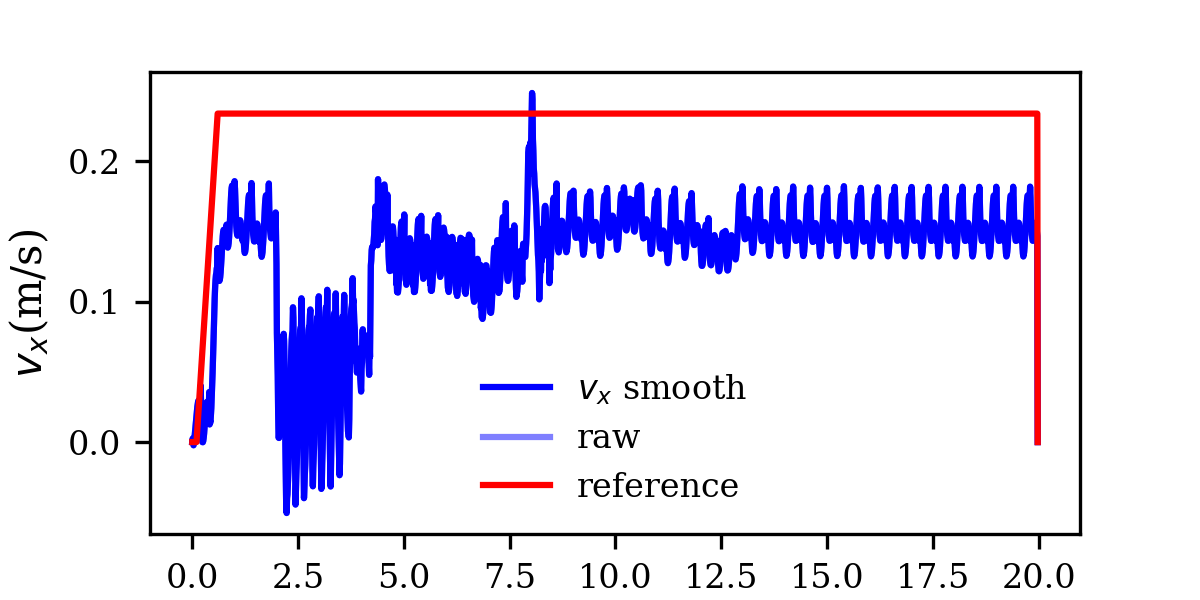

In [21]:
plt.figure(figsize=(4, 2))
use_moving_average = False
filter_size = 20
num_sample = 1
# num_sample = len(velocity_x)
for i in range(num_sample):
    t = (5 * 1/500) * np.arange(velocity_x[i].shape[0])
    if not use_moving_average:
        vx = velocity_x[i]
    else:
        vx = np.convolve(velocity_x[i], np.ones(filter_size)/filter_size, mode='valid')
        # fill missing data
        vx = np.concatenate([vx, np.tile(vx[-1], (len(velocity_x[i]) - len(vx)))], axis=0)
    plt.plot(t[:-1], vx[:-1], label=r"$v_x$ smooth", color="b")
    plt.plot(t[:-1], velocity_x[i][:-1], label="raw", color="b", alpha=0.5)
    plt.plot(t[:-1], desired_velocity_x[i][:-1], label="reference", color="r")
    plt.legend()
    plt.xlabel("time step(s)")
    plt.ylabel(r"$v_x$(m/s)")
# plt.savefig("vx_tracking_v{:.2f}.png".format(desired_velocity_x[0,0]))
# plt.savefig("vx_tracking_infinity.jpg")
plt.show()

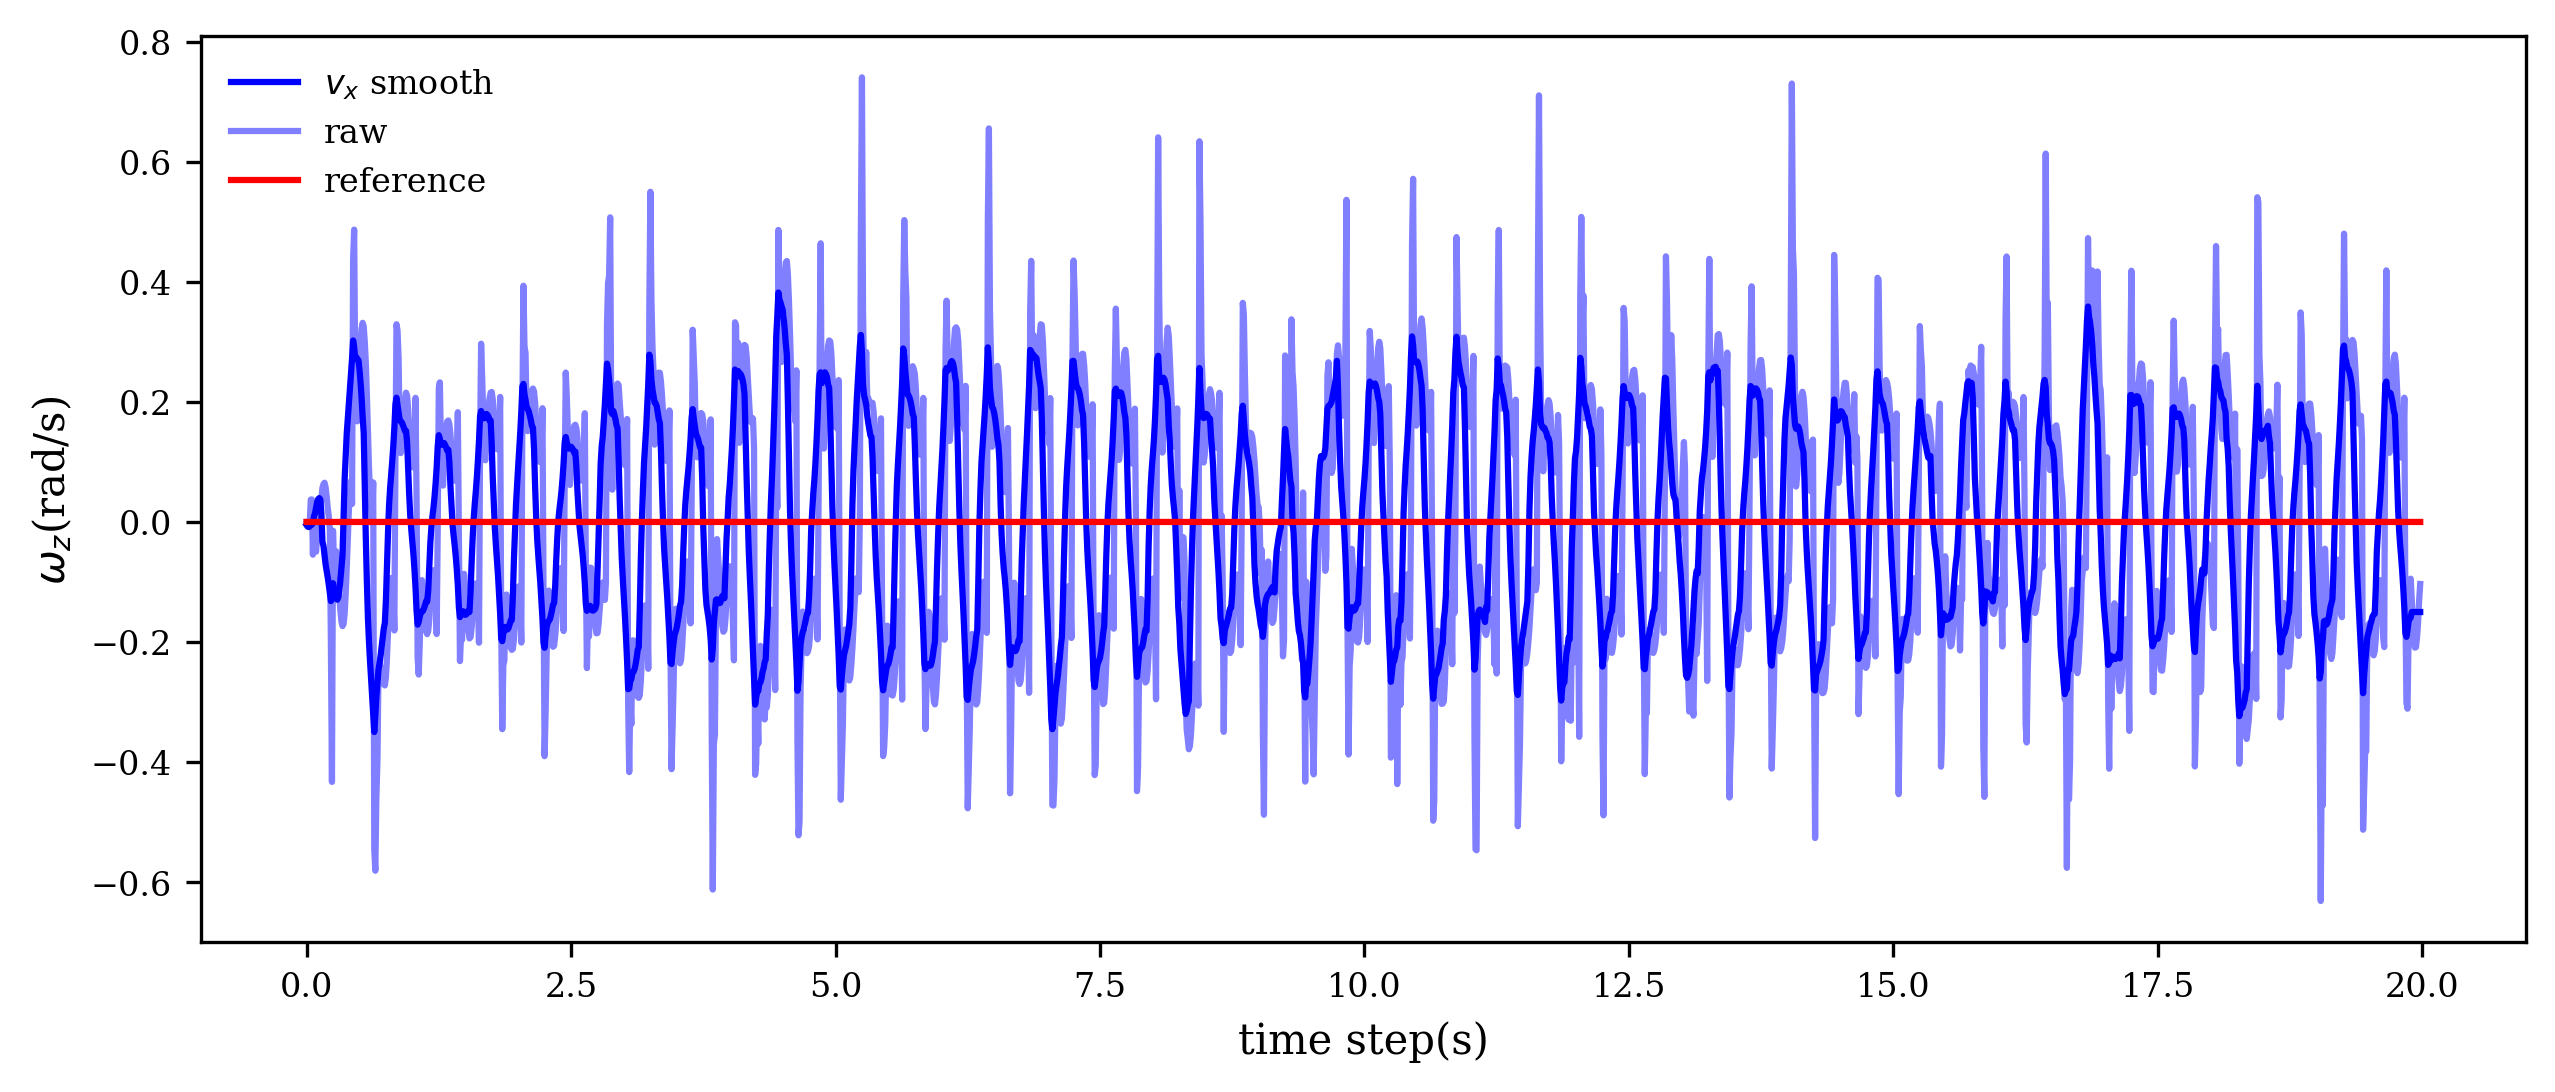

In [ ]:
plt.figure(figsize=(10, 4))
use_moving_average = True
filter_size = 10
num_sample = 1
# num_sample = len(velocity_x)
for i in range(num_sample): 
    t = (5 * 1/500) * np.arange(ang_velocity[i].shape[0]) 
    if not use_moving_average:
        wz = ang_velocity[i]
    else:
        wz = np.convolve(ang_velocity[i], np.ones(filter_size)/filter_size, mode='valid')
        # fill missing data
        wz = np.concatenate([wz, np.tile(wz[-1], (len(ang_velocity[i]) - len(wz)))], axis=0)

    plt.plot(t[:-1], wz[:-1], label=r"$v_x$ smooth", color="b")
    plt.plot(t[:-1], ang_velocity[i][:-1], label="raw", color="b", alpha=0.5)
    plt.plot(t[:-1], desired_ang_velocity[i][:-1], label="reference", color="r")
    plt.legend()
    plt.xlabel("time step(s)")
    plt.ylabel(r"$\omega_z$(rad/s)")
# plt.savefig("wz_tracking_rft.png")
plt.show()

In [44]:
np.max(action_data[0, :, 4])

0.2

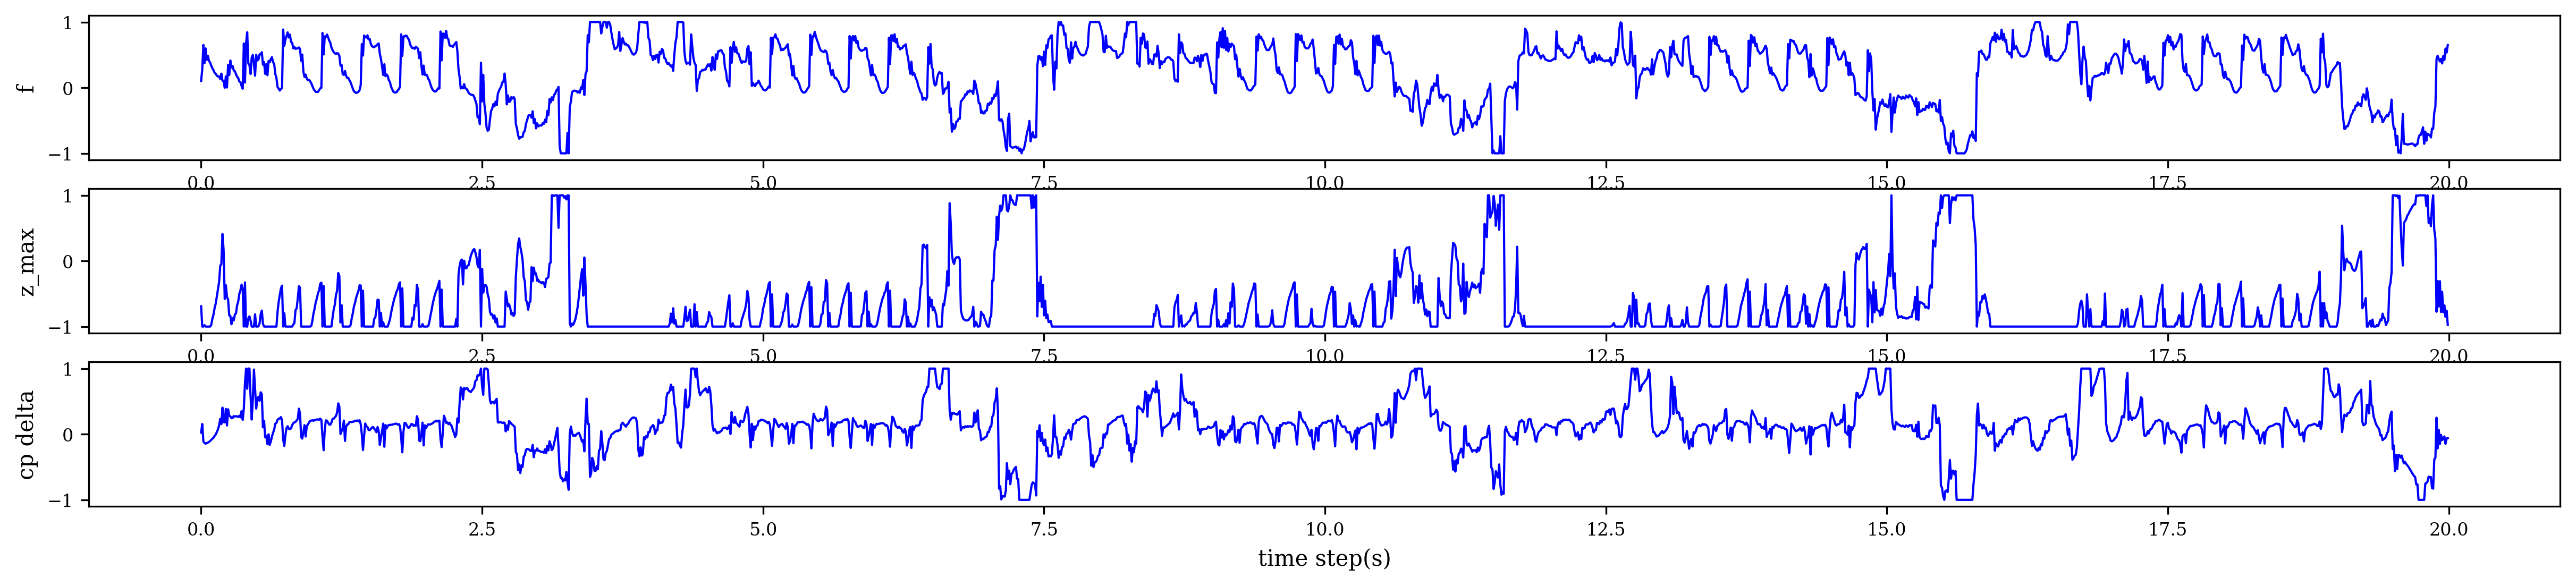

In [6]:
from copy import copy
plt.figure(figsize=(20, 4))
use_moving_average = False
filter_size = 2

cut_off_time = int(20.0*100)
num_sample = 1
for i in range(num_sample): 
    t = (1/100) * np.arange(action_data[i].shape[0]) 
    if not use_moving_average:
        a = copy(action_data[i])
    else:
        a = copy(action_data[i])
        for n in range(6):
            tmp = np.convolve(a[:, n], np.ones((filter_size))/filter_size, mode='valid')
            a[:, n] = np.concatenate([tmp, np.tile(tmp[-1], (len(action_data[i]) - len(tmp)))], axis=0)
    
    num_traj = 4
    plt.subplot(3, 1, 1)
    plt.plot(t[:cut_off_time], a[:, 0][:cut_off_time], label="f_t1", color="blue")
    
    plt.xlabel("time step(s)")
    plt.ylabel("f")
    
    plt.subplot(3, 1, 2)
    plt.plot(t[:cut_off_time], a[:, 1][:cut_off_time], label=r"$z_max$", color="blue")
    plt.xlabel("time step(s)")
    plt.ylabel("z_max")
    
    plt.subplot(3, 1, 3)
    plt.plot(t[:cut_off_time], a[:, 2][:cut_off_time], label=r"$cp$", color="blue")
    
    plt.xlabel("time step(s)")
    plt.ylabel("cp delta")

plt.savefig("action_data.png")

plt.show()

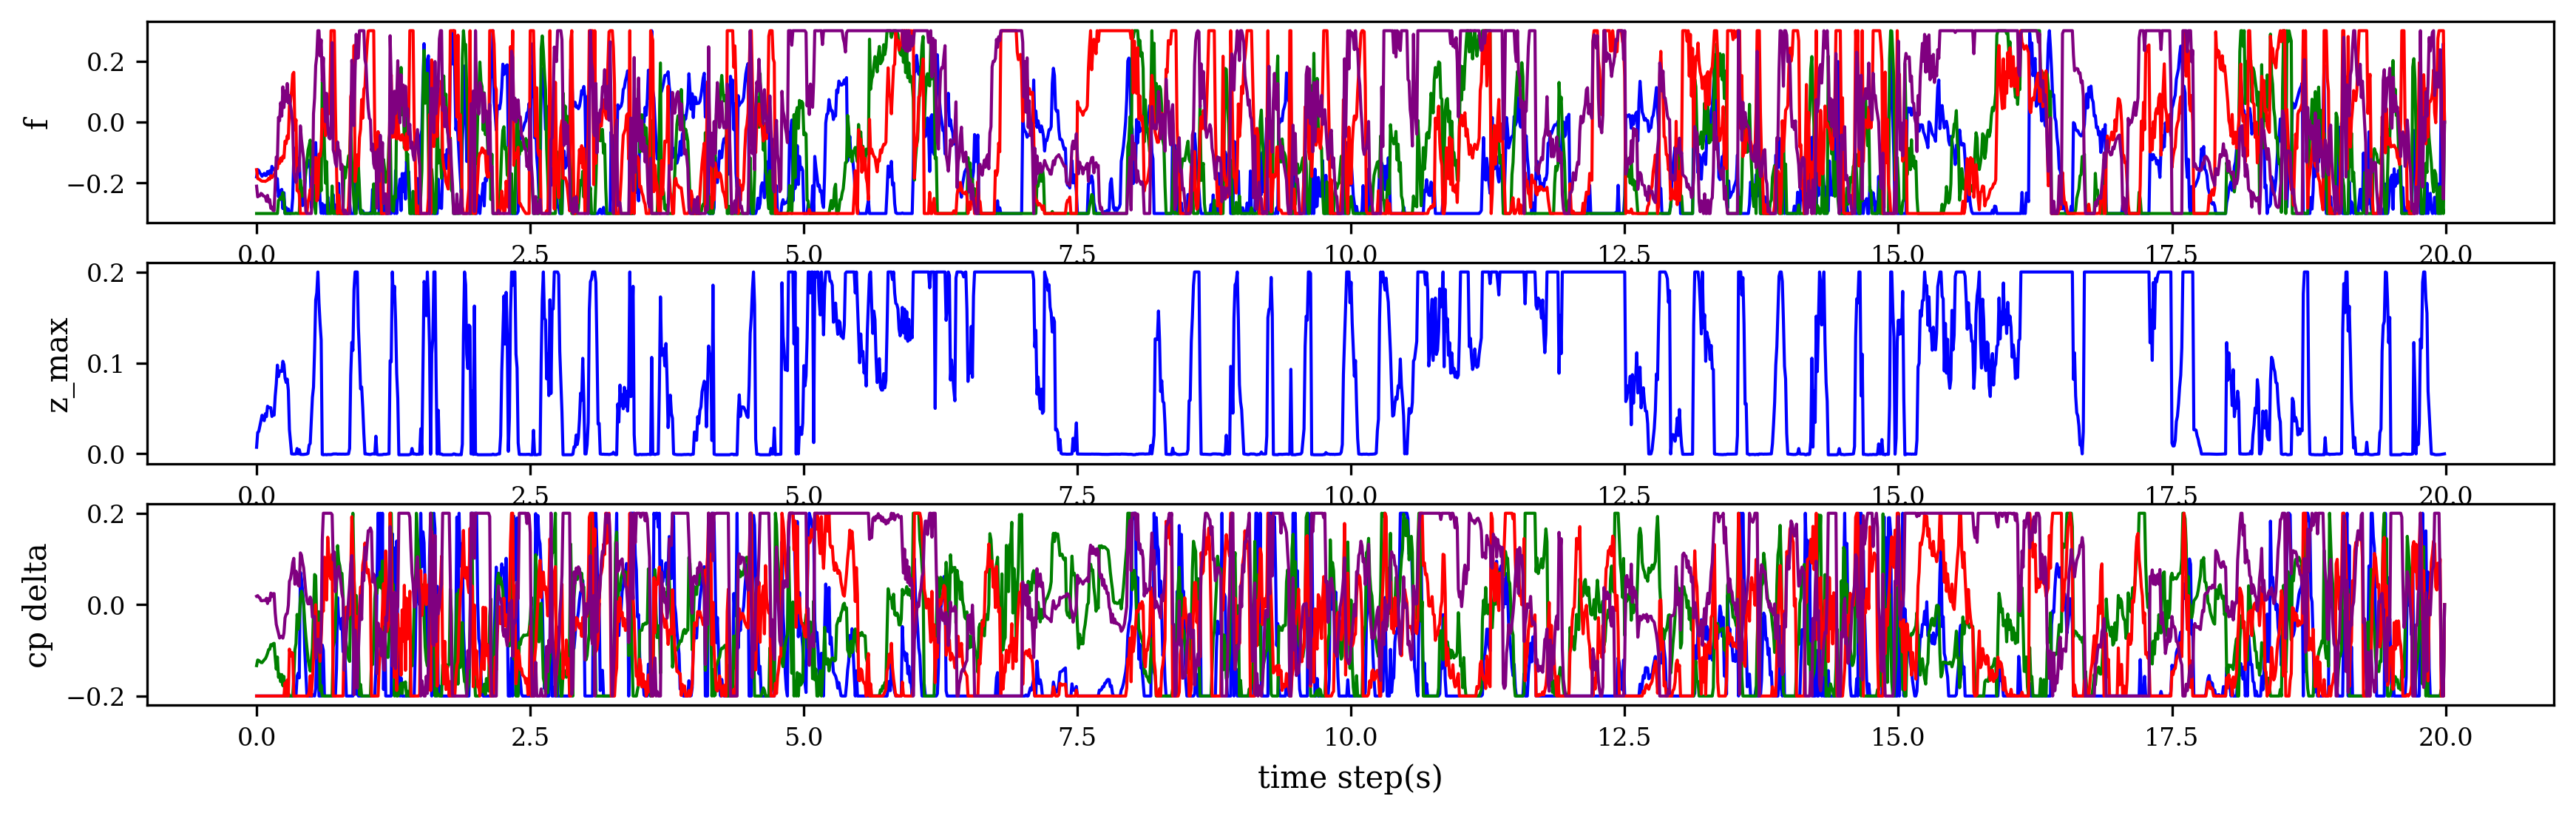

In [68]:
from copy import copy
plt.figure(figsize=(14, 4))
use_moving_average = False
filter_size = 2

cut_off_time = int(20.0*100)
num_sample = 1
for i in range(num_sample): 
    t = (1/100) * np.arange(action_data[i].shape[0]) 
    if not use_moving_average:
        a = copy(action_data[i])
    else:
        a = copy(action_data[i])
        for n in range(6):
            tmp = np.convolve(a[:, n], np.ones((filter_size))/filter_size, mode='valid')
            a[:, n] = np.concatenate([tmp, np.tile(tmp[-1], (len(action_data[i]) - len(tmp)))], axis=0)
    
    num_traj = 4
    plt.subplot(3, 1, 1)
    # plt.plot(t[:cut_off_time], a[:, 0][:cut_off_time], label=r"$a_x$", color="blue")
    plt.plot(t[:cut_off_time], a[:, 0][:cut_off_time], label="f_t1", color="blue")
    plt.plot(t[:cut_off_time], a[:, 1][:cut_off_time], label="f_t2", color="green")
    plt.plot(t[:cut_off_time], a[:, 2][:cut_off_time], label="f_t3", color="red")
    plt.plot(t[:cut_off_time], a[:, 3][:cut_off_time], label="f_t4", color="purple")
    
    plt.xlabel("time step(s)")
    plt.ylabel("f")
    
    plt.subplot(3, 1, 2)
    # plt.plot(t[:cut_off_time], a[:, 1][:cut_off_time], label=r"$a_y$", color="red")
    plt.plot(t[:cut_off_time], a[:, 4][:cut_off_time], label=r"$z_max$", color="blue")
    # plt.plot(t[:cut_off_time], a[:, 5][:cut_off_time], label=r"$z_min$", color="green")
    # plt.plot(t[:cut_off_time], a[:, 6][:cut_off_time], label=r"$z_min$", color="red")
    # plt.plot(t[:cut_off_time], a[:, 7][:cut_off_time], label=r"$z_min$", color="purple")
    plt.xlabel("time step(s)")
    plt.ylabel("z_max")
    
    plt.subplot(3, 1, 3)
    # plt.plot(t[:cut_off_time], a[:, 2][:cut_off_time], label=r"$a_z$", color="green")
    plt.plot(t[:cut_off_time], a[:, 8][:cut_off_time], label=r"$cp$", color="blue")
    plt.plot(t[:cut_off_time], a[:, 9][:cut_off_time], label=r"$cp$", color="green")
    plt.plot(t[:cut_off_time], a[:, 10][:cut_off_time], label=r"$cp$", color="red")
    plt.plot(t[:cut_off_time], a[:, 11][:cut_off_time], label=r"$cp$", color="purple")
    
    plt.xlabel("time step(s)")
    plt.ylabel("cp delta")

plt.show()

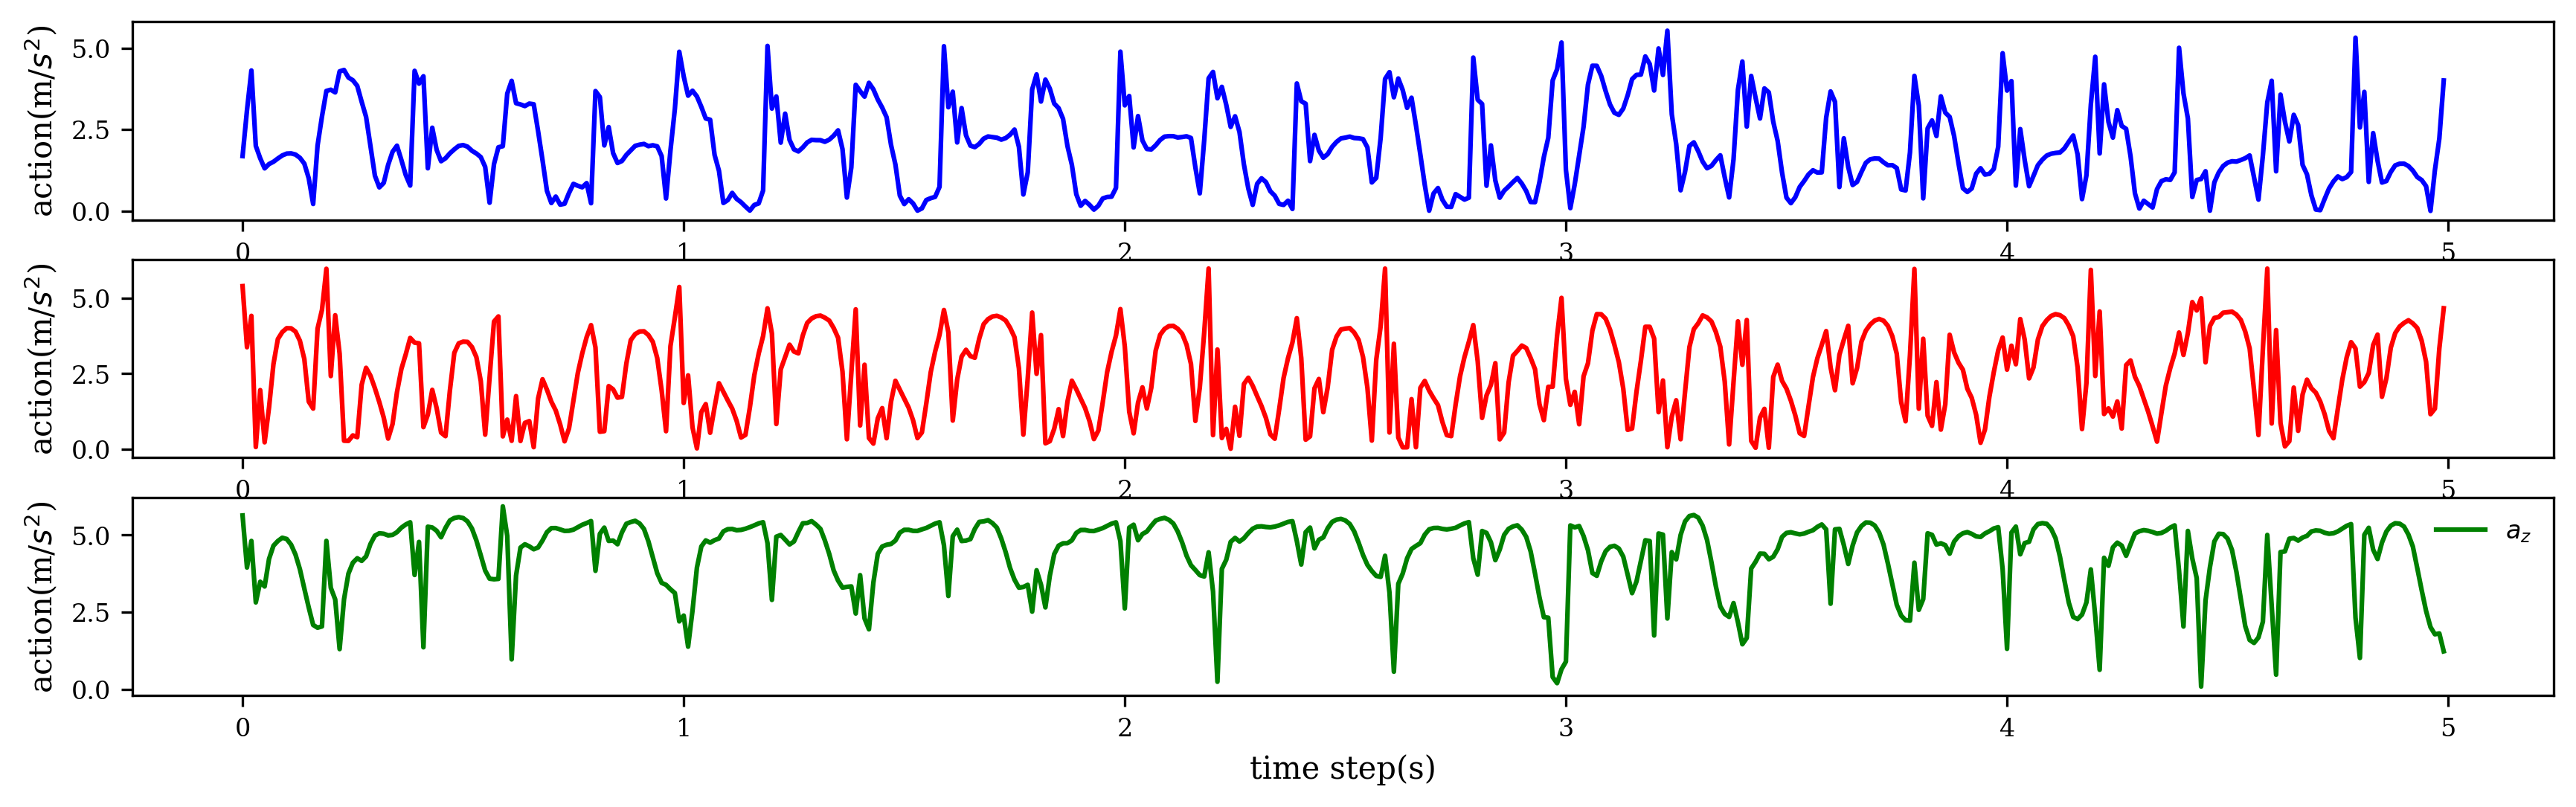

In [ ]:
# from copy import copy
# plt.figure(figsize=(10, 4))
# use_moving_average = False
# filter_size = 2

# cut_off_time = int(10.0*100)
# num_sample = 1
# for i in range(num_sample): 
#     t = (5 * 1/500) * np.arange(action_data[i].shape[0]) 
#     if not use_moving_average:
#         a = copy(action_data[i])
#     else:
#         a = copy(action_data[i])
#         for n in range(6):
#             tmp = np.convolve(a[:, n], np.ones((filter_size))/filter_size, mode='valid')
#             a[:, n] = np.concatenate([tmp, np.tile(tmp[-1], (len(action_data[i]) - len(tmp)))], axis=0)

#     plt.plot(t[:cut_off_time], a[:, 0][:cut_off_time], label=r"$a_x$", color="blue")
#     plt.plot(t[:cut_off_time], a[:, 1][:cut_off_time], label=r"$a_y$", color="red")
#     plt.plot(t[:cut_off_time], a[:, 2][:cut_off_time], label=r"$a_z$", color="green")
#     plt.xlabel("time step(s)")
#     plt.ylabel(r"action(m/$s^2$)")
# plt.legend()
# plt.show()

from copy import copy
plt.figure(figsize=(14, 4))
use_moving_average = False
filter_size = 2

cut_off_time = int(5.0*100)
num_sample = 1
for i in range(num_sample): 
    t = (5 * 1/500) * np.arange(action_data[i].shape[0]) 
    if not use_moving_average:
        a = copy(action_data[i])
    else:
        a = copy(action_data[i])
        for n in range(6):
            tmp = np.convolve(a[:, n], np.ones((filter_size))/filter_size, mode='valid')
            a[:, n] = np.concatenate([tmp, np.tile(tmp[-1], (len(action_data[i]) - len(tmp)))], axis=0)
    
    plt.subplot(3, 1, 1)
    # plt.plot(t[:cut_off_time], a[:, 0][:cut_off_time], label=r"$a_x$", color="blue")
    plt.plot(t[:cut_off_time], np.abs(a[:, 0][:cut_off_time]), label=r"$a_x$", color="blue")
    plt.xlabel("time step(s)")
    plt.ylabel(r"action(m/$s^2$)")
    
    plt.subplot(3, 1, 2)
    # plt.plot(t[:cut_off_time], a[:, 1][:cut_off_time], label=r"$a_y$", color="red")
    plt.plot(t[:cut_off_time], np.abs(a[:, 1][:cut_off_time]), label=r"$a_y$", color="red")
    plt.xlabel("time step(s)")
    plt.ylabel(r"action(m/$s^2$)")
    
    plt.subplot(3, 1, 3)
    # plt.plot(t[:cut_off_time], a[:, 2][:cut_off_time], label=r"$a_z$", color="green")
    plt.plot(t[:cut_off_time], np.abs(a[:, 2][:cut_off_time]), label=r"$a_z$", color="green")
    plt.xlabel("time step(s)")
    plt.ylabel(r"action(m/$s^2$)")
    
plt.legend()
plt.show()

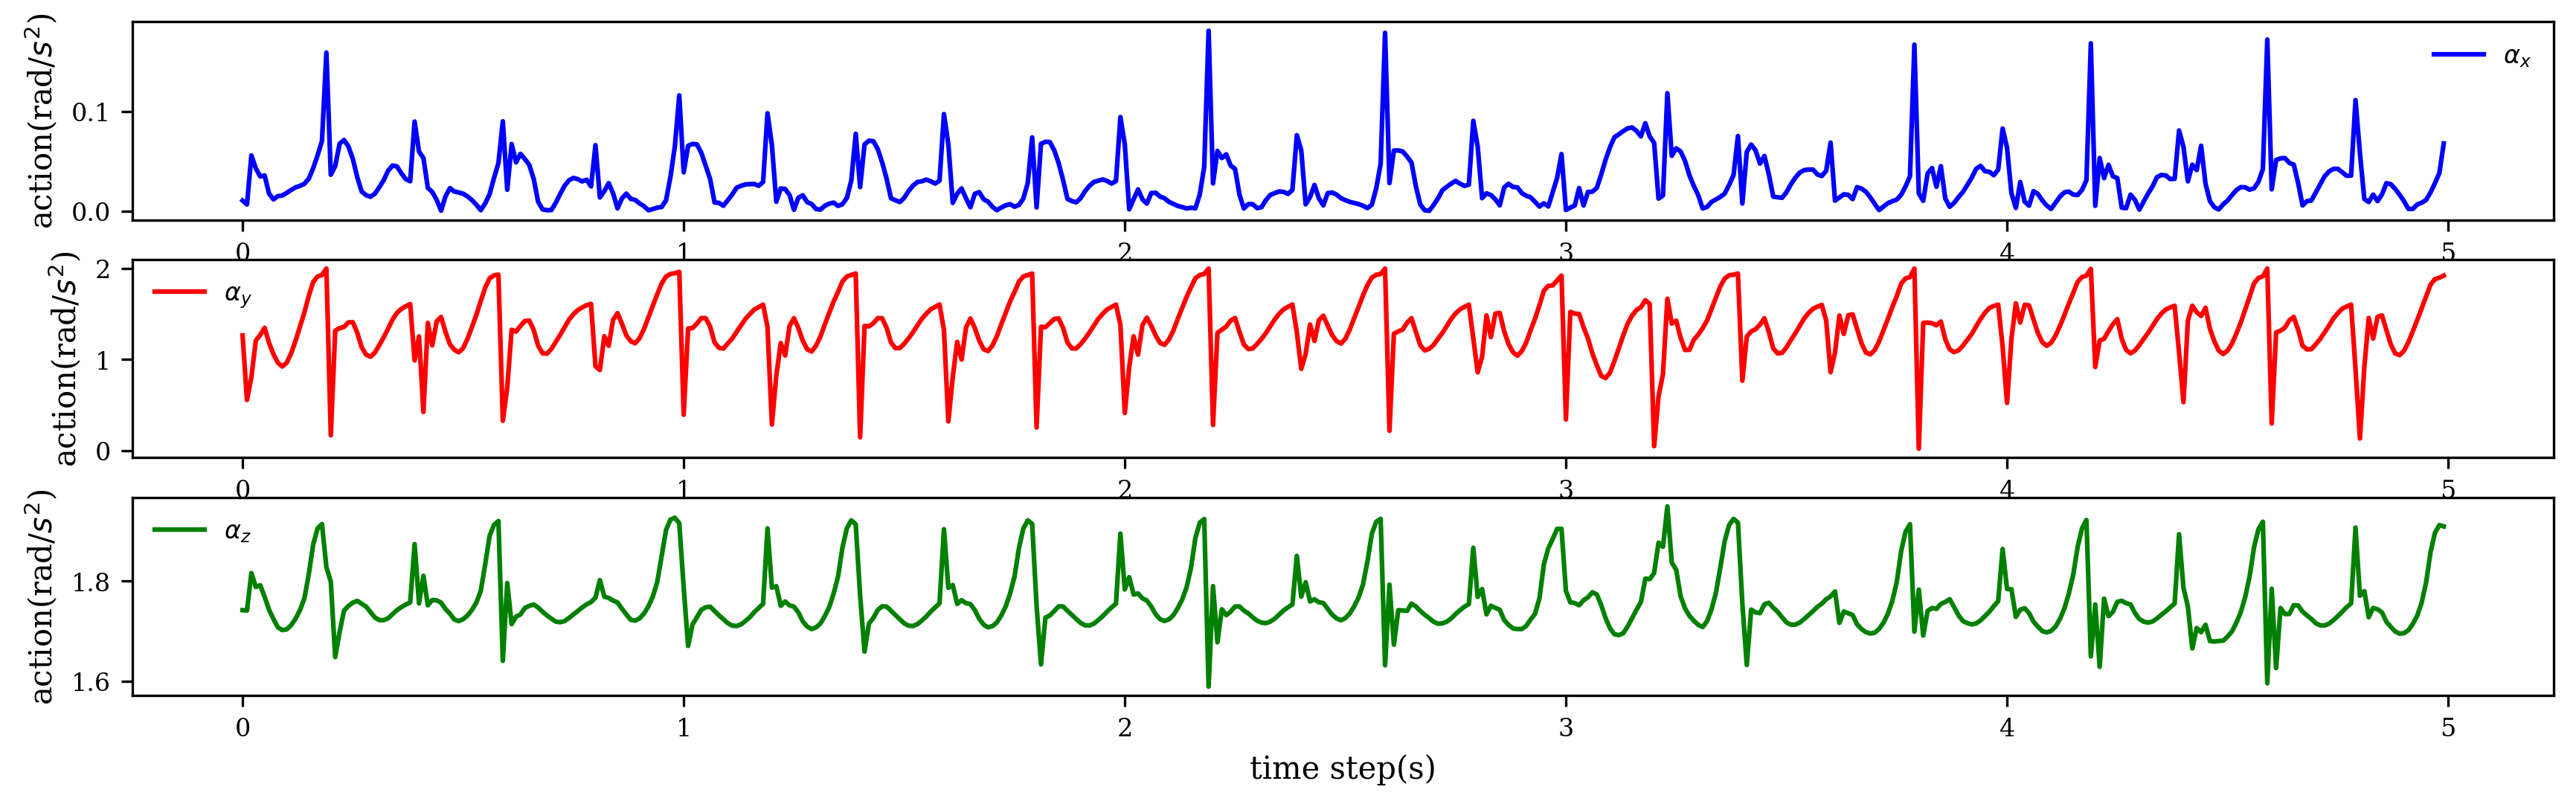

In [131]:
from copy import copy
plt.figure(figsize=(14, 4))
use_moving_average = False
filter_size = 2

cut_off_time = int(5.0*100)
num_sample = 1
for i in range(num_sample): 
    t = (5 * 1/500) * np.arange(action_data[i].shape[0]) 
    if not use_moving_average:
        a = copy(action_data[i])
    else:
        a = copy(action_data[i])
        for n in range(6):
            tmp = np.convolve(a[:, n], np.ones((filter_size))/filter_size, mode='valid')
            a[:, n] = np.concatenate([tmp, np.tile(tmp[-1], (len(action_data[i]) - len(tmp)))], axis=0)
    
    plt.subplot(3, 1, 1)
    # plt.plot(t[:cut_off_time], a[:, 3][:cut_off_time], label=r"$\alpha_x$", color="blue")
    plt.plot(t[:cut_off_time], np.abs(a[:, 3][:cut_off_time]), label=r"$\alpha_x$", color="blue")
    plt.xlabel("time step(s)")
    plt.ylabel(r"action(rad/$s^2$)")
    plt.legend()
    
    plt.subplot(3, 1, 2)
    # plt.plot(t[:cut_off_time], a[:, 4][:cut_off_time], label=r"$\alpha_y$", color="red")
    plt.plot(t[:cut_off_time], np.abs(a[:, 4][:cut_off_time]), label=r"$\alpha_y$", color="red")
    plt.xlabel("time step(s)")
    plt.ylabel(r"action(rad/$s^2$)")
    plt.legend()
    
    plt.subplot(3, 1, 3)
    # plt.plot(t[:cut_off_time], a[:, 5][:cut_off_time], label=r"$\alpha_z$", color="green")
    plt.plot(t[:cut_off_time], np.abs(a[:, 5][:cut_off_time]), label=r"$\alpha_z$", color="green")
    plt.xlabel("time step(s)")
    plt.ylabel(r"action(rad/$s^2$)")
    plt.legend()
plt.show()

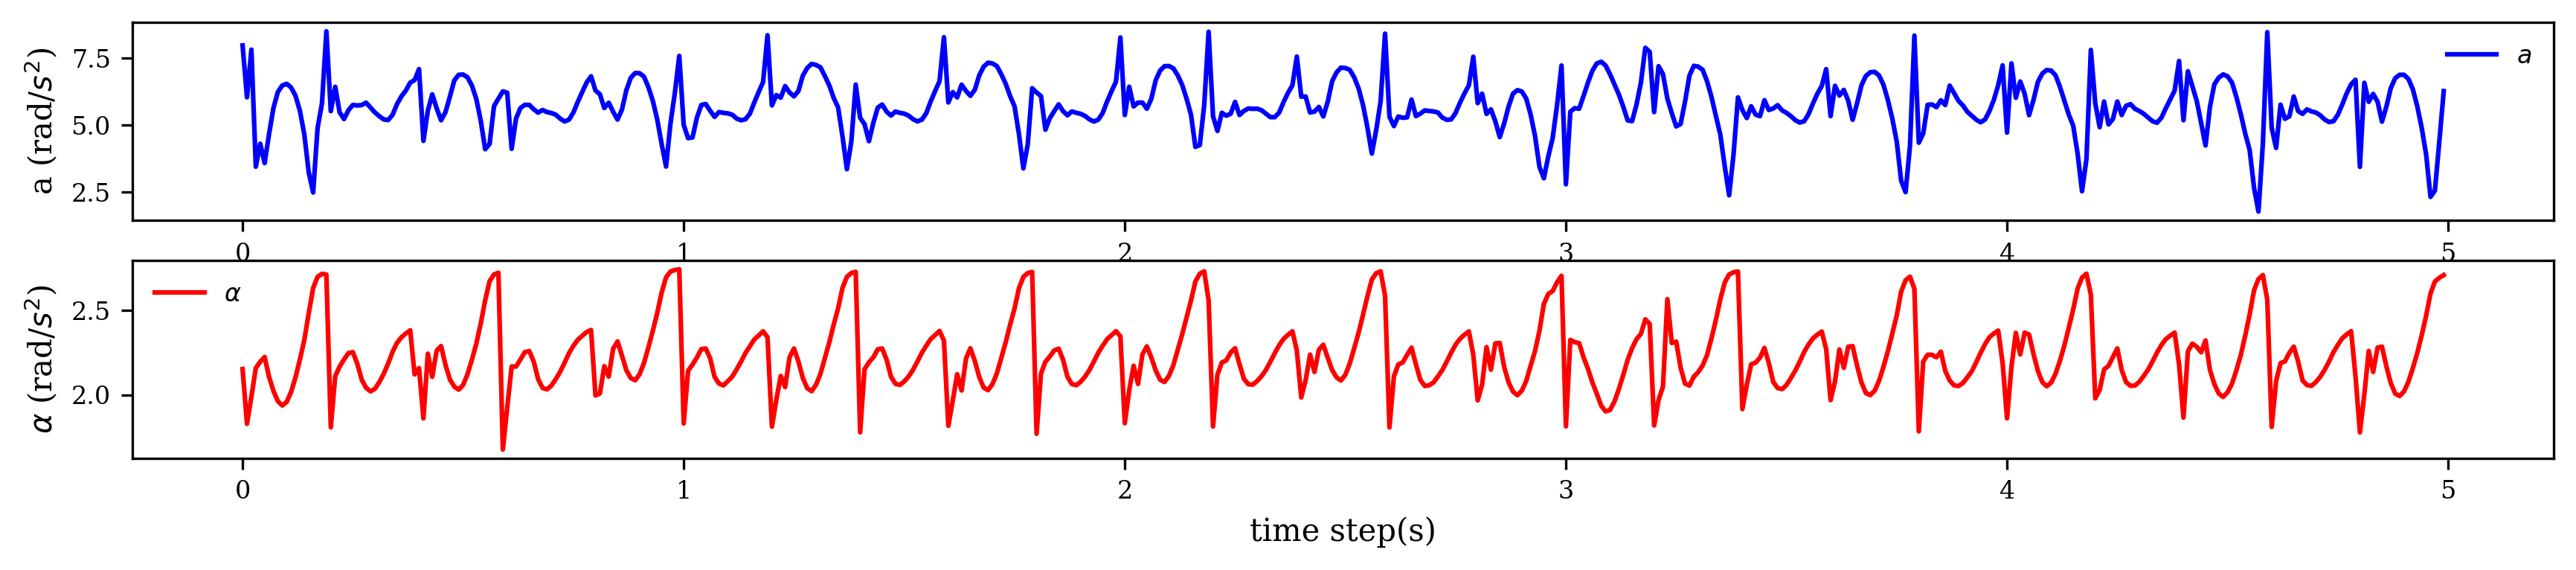

In [132]:
from copy import copy
plt.figure(figsize=(14, 4))
use_moving_average = False
filter_size = 2

cut_off_time = int(5.0*100)
num_sample = 1
for i in range(num_sample): 
    t = (5 * 1/500) * np.arange(action_data[i].shape[0]) 
    if not use_moving_average:
        a = copy(action_data[i])
    else:
        a = copy(action_data[i])
        for n in range(6):
            tmp = np.convolve(a[:, n], np.ones((filter_size))/filter_size, mode='valid')
            a[:, n] = np.concatenate([tmp, np.tile(tmp[-1], (len(action_data[i]) - len(tmp)))], axis=0)
    
    plt.subplot(3, 1, 1)
    plt.plot(t[:cut_off_time], np.linalg.norm(a[:, :3][:cut_off_time], axis=1), label=r"$a$", color="blue")
    plt.xlabel("time step(s)")
    plt.ylabel(r"a (rad/$s^2$)")
    plt.legend()
    
    plt.subplot(3, 1, 2)
    plt.plot(t[:cut_off_time], np.linalg.norm(a[:, 3:6][:cut_off_time], axis=1), label=r"$\alpha$", color="red")
    plt.xlabel("time step(s)")
    plt.ylabel(r"$\alpha$ (rad/$s^2$)")
    plt.legend()
    
    # plt.subplot(3, 1, 3)
    # plt.plot(t[:cut_off_time], a[:, 5][:cut_off_time], label=r"$\alpha_z$", color="green")
    # plt.xlabel("time step(s)")
    # plt.ylabel(r"action(rad/$s^2$)")
    # plt.legend()
plt.show()

In [133]:
# from copy import copy
# plt.figure(figsize=(10, 4))
# use_moving_average = False
# filter_size = 2

# cut_off_time = int(1.0*100)
# num_sample = 1
# for i in range(num_sample): 
#     t = (5 * 1/500) * np.arange(action_data[i].shape[0]) 
#     if not use_moving_average:
#         a = copy(action_data[i])
#     else:
#         a = copy(action_data[i])
#         for n in range(6):
#             tmp = np.convolve(a[:, n], np.ones((filter_size))/filter_size, mode='valid')
#             a[:, n] = np.concatenate([tmp, np.tile(tmp[-1], (len(action_data[i]) - len(tmp)))], axis=0)

#     plt.plot(t[:cut_off_time], a[:, 6][:cut_off_time], label=r"$left_x$", color="blue")
#     plt.plot(t[:cut_off_time], a[:, 7][:cut_off_time], label=r"$right_x$", color="red")
#     plt.plot(t[:cut_off_time], a[:, 8][:cut_off_time], label=r"$left_y$", color="green", linestyle="--")
#     plt.plot(t[:cut_off_time], a[:, 9][:cut_off_time], label=r"$right_y$", color="brown", linestyle="--")
#     plt.xlabel("time step(s)")
#     plt.ylabel(r"action(m)")
# plt.legend()
# plt.show()